## <center> <font size="5"> Using Data Mining to Predict Secondary School Student Performance <br/> by Cortez and Silva, 2008 </font> </center> <br> <font size="4"><center> Computational Statistics Course 2020 - University of Bonn <br> Student Project by Adelina Garamow</center></font> 

<center> <a href="https://pdfs.semanticscholar.org/61d4/68d5254730bbecf822c6b60d7d6595d9889c.pdf?_ga=2.55301101.779715794.1594107255-2097271089.1594107255">P. Cortez and A. M. Gonçalves Silva. "Using data mining to predict secondary school student performance", 2008.</a> <center>

## <center>*Abstract*

*The ability to predict students' performance is useful to optimize schools' resource management. Cortez and Silva (2008) use demographic, social and school-performance data on Portuguese students to show how Data Mining can be applied in the educational sector. They use supervised machine learning algorithms such as Random Forest to predict the performance of students in two core subjects, Mathematics and Portuguese. They conclude that Data Mining methods provide high predictive accuracy and uncover important variables which affect the performance of students. Based on the example, this notebook, joins the discussion on the adequate use of Data Mining methods in the educational sector. More specifically, this notebook explores the question if and in how far Random Forest outperforms Bagging in predicting students' performance. The goal is thereby to predict students' final score in Mathematics. As a basic reference, both methdos are compared to a simple predictor which predicts the last available observation for the students' score. To evaluate the performance of the applied methods, the Mean Squared Error and the Average Prediction Error are used. The results show that Bagging outperforms Random Forest, which provides an even lower prediction accuracy than the simple predictor. The reason is that the data contains only few variables with a strong singnal for the final score and many variables with a low signal, which is measured as the correlation between predictors and the outcome. To demonstrate this, this notebook conducts a simulation study where different subsamples of variables are considered for the training data. The simulation confirms the assumption and shows that Bagging outperforms Random Forest when there is a large discrepancy in explanatory power between the rpedictors in the data set and the number of variables with a weak signal is large. Finally, this study highligths the importance of an adequate application of statistical learning tools. This excersise can be performed analogeously for the Portuguese score.* </center>

***
## *Initial Settings*
***

In [2]:
update.packages(repos='http://cran.rstudio.com/', ask=FALSE, checkBuilt=TRUE)

Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘data.table’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# Load only packages that are not yet installed.
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
    
}


packages.list <- c("MASS", "Matrix", "mvtnorm", "stats", "corrplot", "ggplot2", "reshape",
                   "stargazer", "plyr", "data.table", "dplyr", "polycor", "lattice",
                   "tibble", "caret", "e1071", "fastDummies", "png", "Hmisc", "randomForest",
                   "expss", "tidyr", "devtools")
invisible(ipak(packages.list)) # Mute the output.

#install.packages("GenOrd", repo = 'https://mac.R-project.org')

Loading required package: MASS

Loading required package: Matrix

Loading required package: mvtnorm

Loading required package: corrplot

corrplot 0.84 loaded

Loading required package: ggplot2

Loading required package: reshape


Attaching package: ‘reshape’


The following object is masked from ‘package:Matrix’:

    expand


Loading required package: stargazer


Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 


Loading required package: plyr


Attaching package: ‘plyr’


The following objects are masked from ‘package:reshape’:

    rename, round_any


Loading required package: data.table


Attaching package: ‘data.table’


The following object is masked from ‘package:reshape’:

    melt


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following 

In [4]:
project_path = getwd() # Save project path.
source("auxiliary.R") # Import functions from the auxiliary file.

In [5]:
source("http://pcwww.liv.ac.uk/~william/R/crosstab.r")

<a id="outline"></a>

***
## *Outline*
***

- [1 Introduction](#intro)
- [2 Data](#data)
- [3 Methodology](#method)
    - [3.1 Last available observation](#lao)
    - [3.2 Decision Trees](#dt)
        - [3.2.1 Bagging](#bag)
        - [3.2.2 Random Forest](#rf)
    - [3.3 Evaluation Criteria](#eval)
- [4 Application](#app)
    - [4.1 Last available observation](#applao)
    - [4.2 Bagging](#appbag)
    - [4.3 Random Forest](#apprf)
    - [4.4 Performance Evaluation](#appeval)
- [5 Simulation](#sim)
    - [5.1 Bagging](#simbag)
    - [5.2 Random Forest](#simrf)
    - [5.3 Performance Evaluation](#simeval)
- [6 Conclusion](#conclusion)

***
## *1 Introduction* <a class="anchor" id="intro"></a>
***

The paper by Cortez and Silva (2008) shows how Data Mining (DM) methods can be utilized to predict students' performance to optimize schools' resource management. Their motivation is based on two parallel developments: the emergence of ''big data'' in the educational sector and the increased use of DM methods in social science. They argue that DM methods not only bear the potential to predict students' performance accurately but may also uncover underlying relationships of studdents' performance and demographic, social and school-related characteristics. To demonstrate this, the authors use supervised machine learning algorithms such as Random Forest (RF) to predict the success of students in two core subjects, Mathematics and Portuguese. A Portuguese student is evaluated three times within a school year. The last and final score defines the success of a student for the year. A student passes a class successfully when the score is above ten. To assign the school recourses efficiently, the school needs to predict how strong the final performance will be. Hence, the prediction exercise is to correctly assign the right score between $0$ and $20$ to new students, based on their previous scores in the two core subjects, demographic, social and school-related data. The authors conclude that DM methods provide high predictive accuracy and uncover important variables which affect the performance of students.
    
This notebook, joins the discussion on the adequate use of DM methods in the educational sector by comparing the prediction performance of two supervised machine learning algorithms, RF and Bagging. As a basic reference, both methods are compared to a simple predictor which predicts the last available observation for the final score. This predictor will be referred to as the *LAO predictor*.

First, this notebook uses the above mentioned methods to predict students' final score in Mathematics. Second, it compares the results, evaluating the performance of the appleid methods. More specifically, this notebook explores if RF outperforms Bagging and if so in what cases RF can be expected to outperform Bagging. The evaluation of the prediction performance is based on the two standard measures, the Mean Squared Error and Average Prediction Error. Third, the notebook provides an explanation of the results and finally conducts a simulation study to confirm these.

In theory, RF is expected to further decrease the prediction variance by decorrelating the trees, compared to Bagging. Yet, does the RF always provides a better predictor? Applying the three prediction methods on the training data shows that Bagging outperforms RF while the LAO predictor performs worst. The reason is that the data provides only few variables with a strong signal for the final score and many variables with a low signal. Here the signal strength is determined by the strength of correlation with the response, i.e., the final score in Mathematics. While Bagging learns using all variabels from the training set, RF uses only a random subset of the variables to define optimal decision rules. Consequently, RF might use the important variables, the one with the higher signal only ain the last steps to build the prediction rules or even not at all. In this case, RF decreases the prediction variance while increasing its bias. To demonstrate this, the notebook conducts a simulation study whereby different subsamples of variables are considered for the training data. More specifically, the variables are introduced to the training set based on their signal strength. First, only variables with a very strong signal are considered. Gradually, variables with the next lower signal are added to the traning set. In a second step, this exercise is reverted. At first, only variables with a very low signal are considered. Sequentionally, the varibales with the next higher signal are considererd for the training data. After introducing a variable, the algorithms are build anew and used to predict the final score. The simulation shows that if the varibales with a very low signal dominate the training data set, Bagging will outperform RF. However, if the training data contains variable of equal prediction power or more variables with a higher signal, RF outperforms Bagging.
    
Given the framework of this project, this notebook focuses only on predicting students' scores for Mathematics. However, this excersise can be performed analogeously for the Portuguese score. In the following, the notebook describes the data used, introduces the methodology behind the algorithms, applies and evaluates the three methods, and finally, conducts a simulation study to explore the prediction performance of Bagging and RF for a training set containing variables with a high or low signal.

Please consult the Outline above for an overview of the notebook and an easy navigation within the notebook. For the writing conventions please see Gareth et al. (2013). 

***
## *2 Data* <a class="anchor" id="data"></a>
***

### 2.1 Data description 

The data combines information from two different sources, the administrative mark reports and questionnaires. The mark reports contain scores on the two core subjects, Mathematics and Portuguese and the questionnaires capture self-reported demographic, social and school-related information. Students are evaluated three times over the course of the school year. The third and last evaluation corresponds to the final grade. Like in France, a 20-point grading scale is used, whereby $0$ is the lowest grade and $20$ the highest. Self-reported data captures information on demographics, e.g., age and gender, social background, e.g., education of the parents and quality of family relations, and school-related information, e.g., number of failures or absences in school. The data was collected during the years 2005 - 2006 from two different schools and 395 students in total. The mark reports were recorded in two waves. Hence, two data sets are provided, one which contains information on the Mathematics and Portuguese scores respectively. Yet, the data can be merged as instructed by the authors, leaving 382 observations. In this notebook, the data is merged to include the previous, but not final, Portuguese scores which help to predict the final Mathematics scores. <br/>
The Figure 1 below represents the description of all variables in the original data set.

<center> Figure 1: Variable description </center>
    
<img src= "images/variable_description.PNG" height="600" width="600" /> 

*_Source_ : Cortez and Silva, 2008*

To proceed with the summary statististics, the original data, provided by the authors, needs to be imported and adapted for the presentation.

### 2.2 Data management

In [7]:
# Load the original data, for Mathematics. 
student_math_df <- read.csv("original_data/student_mat.csv", header=TRUE, sep=";")
student_port_df <- read.csv("original_data/student_por.csv", header=TRUE, sep=";")

In [8]:
# Rename the score variables for the merge.
student_math_df <- rename(student_math_df, c("G1_math"="G1", "G2_math"="G2", "G3_math"="G3"))
student_port_df <- rename(student_port_df, c("G1_port"="G1", "G2_port"="G2", "G3_port"="G3"))

In [9]:
# Merge data sets as indicated by the authors.
student_df <- merge(student_math_df, student_port_df, by=c("school", "sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"))
print(nrow(student_df)) # 382 students.

[1] 382


In [10]:
# Drop variables from the Portuguese data set, keep only the scores for Portuguese.
student_df <- student_df[-grep(pattern = "\\.y", names(student_df))]
names(student_df) <- gsub('\\.x', '', names(student_df)) # And remove the .x in the end.

In [11]:
# However, keep only the first two scores for Portuguese, not the final one, drop G3_port.
student_df <- subset(student_df, select = -c(G3_port) )

Now, let's explore the data for the analysis.

In [12]:
head(student_df)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,goout,Dalc,Walc,health,absences,G1_math,G2_math,G3_math,G1_port,G2_port
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,15,R,GT3,T,1,1,at_home,other,⋯,2,1,1,1,2,7,10,10,13,13
2,GP,F,15,R,GT3,T,1,1,other,other,⋯,4,2,4,5,2,8,6,5,13,11
3,GP,F,15,R,GT3,T,2,2,at_home,other,⋯,1,1,1,2,8,14,13,13,14,13
4,GP,F,15,R,GT3,T,2,4,services,health,⋯,2,1,1,5,2,10,9,8,10,11
5,GP,F,15,R,GT3,T,3,3,services,services,⋯,1,2,3,3,8,10,10,10,13,13
6,GP,F,15,R,GT3,T,3,4,services,health,⋯,2,1,1,5,2,12,12,11,11,12


The data set contains nominal variables, like "sex" or "Mjob", which are coded as strings. Therefore, the string variables are translated to numeric variables and represent the different categories such as female, "F" and male "M" in numbers (0, 1). 

In [13]:
# Write a "recode function" that revalues categorical string variables to numerical variables.
recode_vars_func <- function(df) {
    df$sex <- mapvalues(df$sex, from = c('M', 'F'), to = c(0, 1))
    df$school <- mapvalues(df$school, from = c('GP', 'MS'), to = c(0, 1))
    df$address <- mapvalues(df$address, from = c('U', 'R'), to = c(0, 1))
    df$famsize <- mapvalues(df$famsize, from = c('LE3', 'GT3'), to = c(0, 1))
    df$Pstatus <- mapvalues(df$Pstatus, from = c('A', 'T'), to = c(0, 1))
    df$Mjob <- mapvalues(df$Mjob, from = c('at_home', 'health', 'services', 'teacher', 'other'), to = c(1, 2, 3, 4, 5))
    df$Fjob <- mapvalues(df$Fjob, from = c('at_home', 'health', 'services', 'teacher', 'other'), to = c(1, 2, 3, 4, 5))
    df$reason <- mapvalues(df$reason, from = c('home', 'course', 'reputation', 'other'), to = c(1, 2, 3, 4))
    df$nursery <- mapvalues(df$nursery, from = c('no', 'yes'), to = c(0, 1))
    df$internet <- mapvalues(df$internet, from = c('no', 'yes'), to = c(0, 1))
    df$guardian <- mapvalues(df$guardian, from = c('father', 'mother', 'other'), to = c(1, 2, 3))
    df$schoolsup <- mapvalues(df$schoolsup, from = c('no', 'yes'), to = c(0, 1))
    df$famsup <- mapvalues(df$famsup, from = c('no', 'yes'), to = c(0, 1))
    df$paid <- mapvalues(df$paid, from = c('no', 'yes'), to = c(0, 1))
    df$activities <- mapvalues(df$activities, from = c('no', 'yes'), to = c(0, 1))
    df$higher <- mapvalues(df$higher, from = c('no', 'yes'), to = c(0, 1))
    df$romantic <- mapvalues(df$romantic, from = c('no', 'yes'), to = c(0, 1))
    df
}

In [14]:
# Recode string to numeric variables. Please let this funciton only run once.
student_df <- recode_vars_func(student_df)

In [15]:
names(student_df)

[1] "school"     "sex"        "age"        "address"    "famsize"   
 [6] "Pstatus"    "Medu"       "Fedu"       "Mjob"       "Fjob"      
[11] "reason"     "nursery"    "internet"   "guardian"   "traveltime"
[16] "studytime"  "failures"   "schoolsup"  "famsup"     "paid"      
[21] "activities" "higher"     "romantic"   "famrel"     "freetime"  
[26] "goout"      "Dalc"       "Walc"       "health"     "absences"  
[31] "G1_math"    "G2_math"    "G3_math"    "G1_port"    "G2_port"

Now, let's look again at the transformed data before continuing with the summary statistics.

In [17]:
head(student_df)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,goout,Dalc,Walc,health,absences,G1_math,G2_math,G3_math,G1_port,G2_port
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,1,15,1,1,1,1,1,1,5,⋯,2,1,1,1,2,7,10,10,13,13
2,0,1,15,1,1,1,1,1,5,5,⋯,4,2,4,5,2,8,6,5,13,11
3,0,1,15,1,1,1,2,2,1,5,⋯,1,1,1,2,8,14,13,13,14,13
4,0,1,15,1,1,1,2,4,3,2,⋯,2,1,1,5,2,10,9,8,10,11
5,0,1,15,1,1,1,3,3,3,3,⋯,1,2,3,3,8,10,10,10,13,13
6,0,1,15,1,1,1,3,4,3,2,⋯,2,1,1,5,2,12,12,11,11,12


### 2.3 Summary statistics

First, the dummy variables in the data set are recoded from 1 and 2 to 0 and 1, for an easier interpretation. Second, the variables are saved as numeric variables. However, the summary table is not suitable for every variable, e.g., it makes little sense to summarize nominal variables like "Mjob" or "Fjob". Therefore, these variabels are excluded from the following summary table.

In [18]:
# Declare the variables as numeric variables for the summary stats.
student_df <- as.data.frame(lapply(student_df, function(x) as.numeric(as.character(x))))

In [19]:
stargazer(student_df[!names(student_df) == c("Mjob", "Fjob")], nobs = FALSE, mean.sd = TRUE, min.max = TRUE,
          median = TRUE, iqr=F, omit.summary.stat = c("p25", "p75"),
          type = "text", title = "Table 1: Summary Statistics")


Table 1: Summary Statistics
Statistic   Mean  St. Dev. Min Median Max
-----------------------------------------
school     0.105   0.307    0    0     1 
sex        0.518   0.500    0    1     1 
age        16.586  1.173   15    17   22 
address    0.212   0.409    0    0     1 
famsize    0.728   0.446    0    1     1 
Pstatus    0.901   0.300    0    1     1 
Medu       2.806   1.086    0    3     4 
Fedu       2.565   1.096    0    3     4 
reason     2.147   0.939    1    2     4 
nursery    0.812   0.392    0    1     1 
internet   0.848   0.359    0    1     1 
guardian   1.804   0.492    1    2     3 
traveltime 1.442   0.695    1    1     4 
studytime  2.034   0.846    1    2     4 
failures   0.291   0.729    0    0     3 
schoolsup  0.134   0.341    0    0     1 
famsup     0.623   0.485    0    1     1 
paid       0.463   0.499    0    0     1 
activities 0.526   0.500    0    1     1 
higher     0.953   0.212    0    1     1 
romantic   0.317   0.466    0    0     1 
famre

Looking at the summary statistics, the variable "absences" shows a large relatively variance. The average of three absences and the maximum number of absences, 75 show that there is an outlier in the data. In order to avoid the situation where the training of the algorithms are driven by the outlier, the variable "absences" is trimmed in the following.

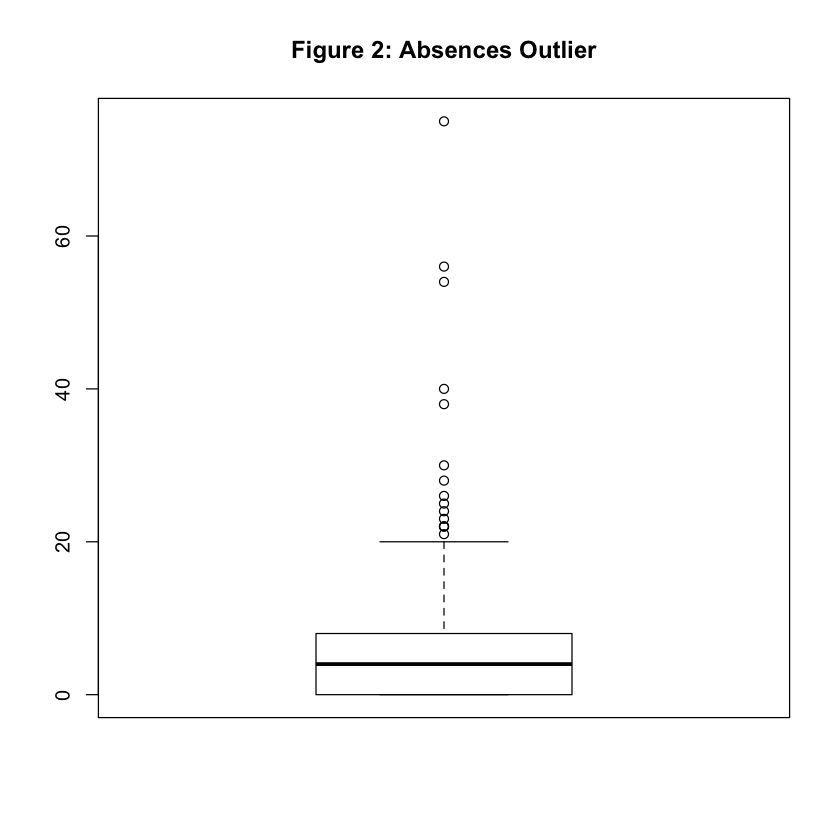

In [20]:
# Look at the outlier in absences.
boxplot(student_math_df$absences, main = "Figure 2: Absences Outlier")

In [21]:
# Impute absences.
trimming_func <- function(x) {
    # Impute the lowest and the highest one percent with the 1st and the 99th percentile.
    quantiles <- quantile( x, c(.01, .99 ) )
    x[ x < quantiles[1] ] <- quantiles[1]
    x[ x > quantiles[2] ] <- quantiles[2]
    x
    
}

In [22]:
student_df$absences <- trimming_func(student_df$absences )

### 2.4 Heatmap

To ensure an easy and wuick overlook of the heatmap, only a subset of the variables in the data are represented in the heatmap.

In [24]:
# Subset of variables that will be considered for the heatmap.
selected_var_vec <- c('G3_math', 'G2_math', 'G1_math', 'G2_port', 'G1_port', 'Medu', 'higher', 'Fedu', 'paid', 'internet', 'studytime', 'reason',
                     'nursery', 'famrel', 'absences', 'activities', 'freetime', 'Mjob', 'Fjob', 'famsup',
                     'school', 'Walc', 'Dalc', 'Pstatus', 'health', 'guardian', 'famsize', 'schoolsup')

In [25]:
# Calculate the coorelation matrix for the heatmap.
# Remember that for categorical variabels, the spearman correlation can be used.
student_df_short_cormat <- round(cor(student_df[selected_var_vec], method = "spearman"), 2)

In [27]:
# Save the heatmap as png and show the heatmap.
png(file="images/heatmap.png", width = 3.25, height = 3, units = "in", res = 1200, pointsize = 4)
my_palette <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))
corrplot(student_df_short_cormat, method = "color", col = my_palette(200),
         type = "upper", number.cex = .55, tl.cex = 0.9,
         addCoef.col = "black", # Add coefficient of correlation.
         tl.col = "black", tl.srt = 60, outline = TRUE, tl.pos = "td", # Text label color and rotation. 
         # Hide correlation coefficient on the principal diagonal.
         diag = FALSE)
dev.off()

pdf 
  2

<center> Figure 3: Heatmap of selected variables
    
<img src= "images/heatmap.png" height="700" width="800" /> 

In the following line shows the variables names which are sorted by their correlation with the response, the final score in Mathematics, "G3_math". The first variable has the strongest correlarion with "G3_math" while the last variable has the lowest. In this example, the previous scores in Mathematics, "G2_Math" and "G1_math", have the strongest correlation with the final score, followed by the previous scores in Portuguese. Having a romantic relationship, "romantic", age and failures within a school year expose the lowest correlation with the final score in Mathematics.

In [28]:
names(sort(cor(student_df)[, 33], decreasing = TRUE))[-1]

[1] "G2_math"    "G1_math"    "G2_port"    "G1_port"    "higher"    
 [6] "Medu"       "Fedu"       "paid"       "reason"     "studytime" 
[11] "internet"   "famrel"     "absences"   "nursery"    "activities"
[16] "freetime"   "Mjob"       "Fjob"       "Walc"       "Dalc"      
[21] "famsup"     "Pstatus"    "health"     "school"     "schoolsup" 
[26] "guardian"   "address"    "goout"      "famsize"    "sex"       
[31] "traveltime" "romantic"   "age"        "failures"

### 2.5 Distribution of the final score

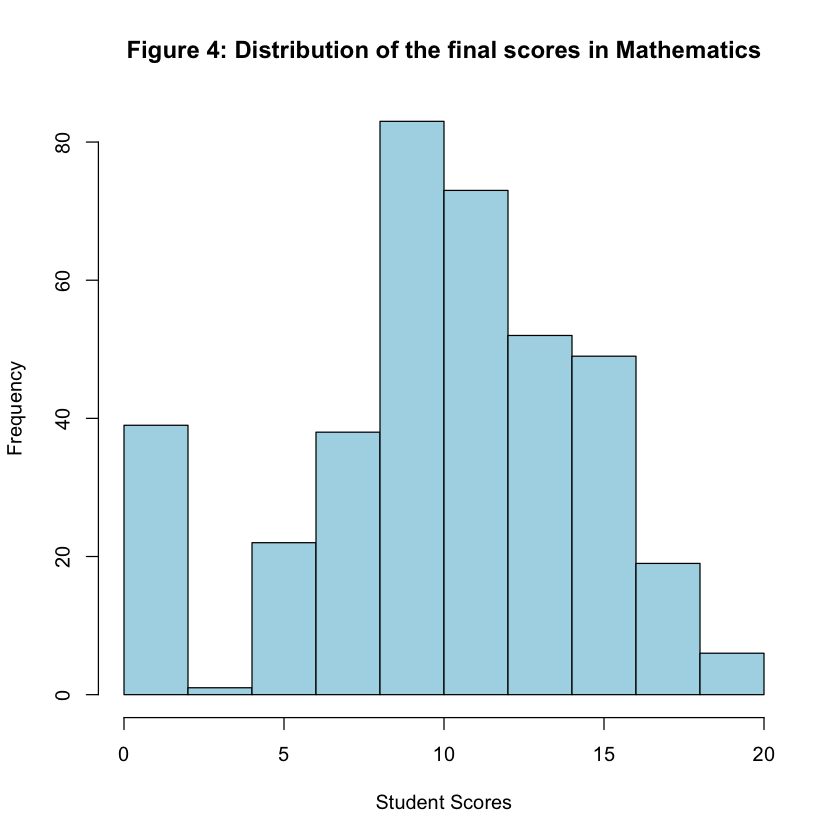

In [29]:
# Distribution of the final grades in Mathematics.
hist(student_df$G3_math, col="lightblue", xlab="Student Scores", 
     ylab="Frequency", main="Figure 4: Distribution of the final scores in Mathematics")

The distribution of the final scores in Mathematics exposes a slightly right-skewed bell shape and a relative large number of students who fail (10 percent of all students). The following figure shows the number of students who have passed or failed the subject Mathematics. 

In [30]:
G3_passed_num <- as.numeric(ifelse(student_df$G3_math >= 10, "1", "0"))

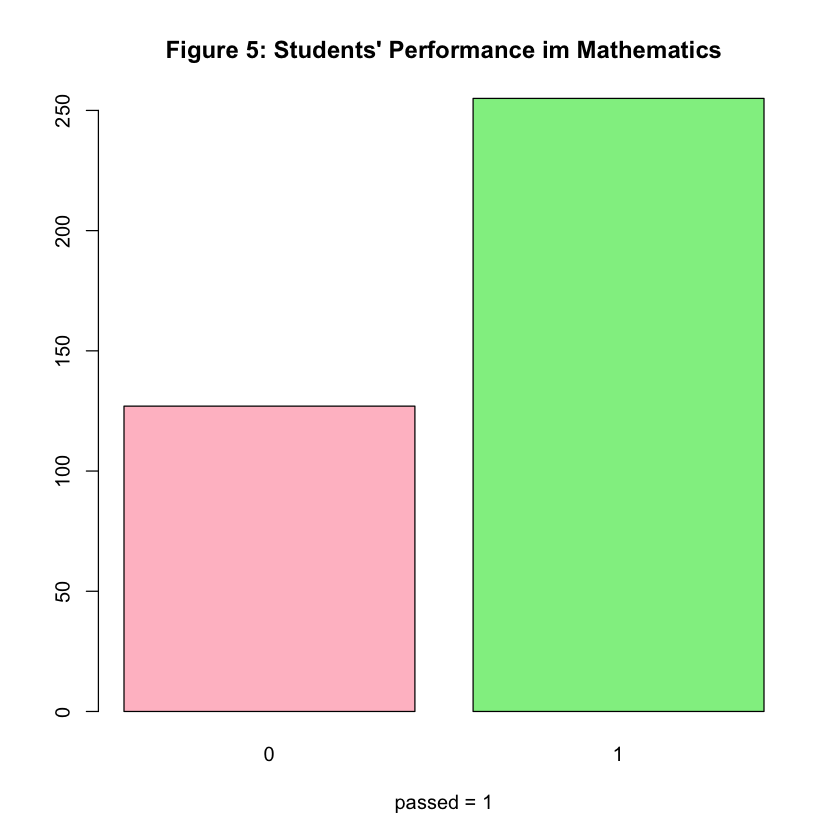

In [31]:
barplot(table(G3_passed_num) , main="Figure 5: Students' Performance im Mathematics", xlab="passed = 1", 
       col=c("pink", "lightgreen"), beside = TRUE)

The Figure 5 shows that almost one third of the students fail to pass the core subject Mathematics. 

### 2.6 Crosstabulation of the scores

The following two cross-tabulations show how many students have failed or passed the final evaluation conditional on passing the previous two evaluations in Mathematics and Portuguese respectively. The last tabulation shows how many students have passed the final evaluation in Mathematics conditional on being in a romantic relationship. The tabulations emphasize the strong correlation between the previous scores and the final score while underlining the weak correlation between the final scores and being in a romantic relationship. 

In [53]:
# Crosstabulation of last score and final scores.
G3_math_passed <- ifelse(student_df$G3_math >= 10, "passed", "failed")
G2_math_passed <- ifelse(student_df$G2_math >= 10, "passed", "failed")
G1_math_passed <- ifelse(student_df$G1_math >= 10, "passed", "failed")

G3_port_passed <- ifelse(student_df$G3_port >= 10, "passed", "failed")
G2_port_passed <- ifelse(student_df$G2_port >= 10, "passed", "failed")
G1_port_passed <- ifelse(student_df$G1_port >= 10, "passed", "failed")

In [54]:
passed_math_tab <- table(G3_math_passed, G2_math_passed, G1_math_passed)
passed_math_tab

, , G1_math_passed = failed

              G2_math_passed
G3_math_passed failed passed
        failed     96      4
        passed     20     20

, , G1_math_passed = passed

              G2_math_passed
G3_math_passed failed passed
        failed     22      5
        passed      6    209


In [57]:
passed_math_port_tab <- table(G3_math_passed, G2_port_passed, G1_port_passed)
passed_math_port_tab

, , G1_port_passed = failed

              G2_port_passed
G3_math_passed failed passed
        failed     27      8
        passed      9     11

, , G1_port_passed = passed

              G2_port_passed
G3_math_passed failed passed
        failed     12     80
        passed      6    229


The first cross-tabulations shows that 209 students out of 213 students, who passed both previous evaluations in Mathematics, also have passed the final evaluation. In other words, 98 percent of students pass the final evaluation given that they have passed the previous two evaluations. At the same time, 78 percent of students fail the final evaluation given that they have failed the previous two evaluations in Mathematics. A similar pattern, however less pronounced, is observed for students who have passed the two previous evaluations in Portuguese.

In [58]:
passed_math_romance_tab <- table(G3_math_passed, student_df$romantic)
passed_math_romance_tab

              
G3_math_passed   0   1
        failed  78  49
        passed 183  72

The last tabulations shows that there is not a clear pattern of failing or passing the final evaluation in Mathematics conditional on being in a romantic relationship. Approximately 60 percent of students who are in a relationship and 70 percent of single students pass the final evaluation.

***
##  *3 Methodology* <a class="anchor" id="method"></a>
***

Statistical learning is used to extract useful information from data to learn about underlying relationships between a set of explanatory variabels and an outcome variable. Usually, a systematic relationship between some explanatory variables, $X$ and $y$ is assumed. The systematic relationship between predictors and a response can be represented in a very general form as follows.

<br/>
 <center> $ y = f(X) + \epsilon $ </center>
 
Here, $f$ represents the systematic information that $X$ provides about $y$, and $\epsilon$ is a random error term which is independent of $X$ and has a zero mean. Typically, $f$ is unknown and must be estimated based on available observations. With a zero-mean error, the outcome $y$ can be predicted using an estimate for $f$. 

<br/>
 <center> $ \hat y = \hat f(X) $ </center>
 
Thereby, $\hat f$ represents an estimate for $f$ and $\hat y$ is the resulting prediction for $y$. Therefore, the goal of statitical learning methods is to use a learning algorithm on some training data in order to estimate the function $f$ such that $\hat f(X) \approx y$ for any observation.

This notebook uses two supervised learning algorithms, Bagging and Random Forest and a simple predictor, the LAO predictor to predict students' scores in Mathematics based on demographic, social and school-related data. Thereby, the challenge is to correctly assign a score between $0$ and $20$ to a new student from the test data. In the following, the three methods applied in this norebook are described in more detail below.

### 3.1 The last available observation - LAO <a class="anchor" id="lao"></a>

For the baseline comparison, a simple predictor which predicts the last available observation for the response is used. In this case, the LAO predictor predicts the second evaluation for Mathematics for the final evaluation. For instance, if a student has $8$ in the first evaluation, "G1_math" and $11$ in the second evaluation, "G2_math", the LAO predictor would predict $11$ for the final score. Then we have: $\hat f$ = G2_math.

### 3.2 Decision Trees <a class="anchor" id="dt"></a>

Decision Trees (DT) provide the foundation for the two statistical learning methods, used in this notebook, Bagging and RF. Therefore, the understanding of the two methods requires an introduction of DT methods in general.

DT can be used for a regression or classification problem. A regression tree is used to predict a quantitative response. To predict the response for an observation, DT methods cluster observations by splitting the predictor space into a number of regions. Then, the average of each region is taken as the prediction for an observation that falls into that region. Therefore, apart from the predicted region, the variance of a region is important for the accuracy of prediction. <br/> 
The predictor space is stratified by a set of simple *IF-THEN decision rules* that distinguish attribute values in a hierachical form. For instance, in the first step the predictor space might be divided into two regions by putting all students with a previous score above ten in one region and students with a perevious score below ten in the second region. In the second step, the two resulting groups can be divided further into two additional groups respectively by another attribute, like the education of the mother. The decision rules are applied in this manner until the predictor space is split such that each group contains a desired number of observations. <br/>
These decision rules resemble branches of a tree wich is turned upside down (Breiman et al. 1984). 

<br/>
<center>
    Figure 6: Basic decision tree algorithm
<table><tr>
<td> <img src= "images/segmentation.PNG" height="500" width="500" />  </td>
<td> <img src= "images/decision_tree.PNG" height="500" width="500" />  </td>
</tr></table>

_Source_ : Hastie, Tibshirani and Friedman, 2009

The left-hand side shows a predictor space split into five regions, $R_1 - R_5$. The right-hand side represents the splitting rules in a decision tree. Using the tree terminology, the resulting reagions at the bottom of the tree, $R_1 - R_5$, are called terminal nodes or leaves. The splitting points are called internal nodes. The connection between two nodes is referred to as branches. Each node represents a characteristic by which an observations can be assigned to one or the other group, and each branch represents the value attached to it.    
The goal of a DT is to divide the predictor space into $J$ distinct and non-overlapping reagions, $R_1, ..., R_J$ such that the partition results in the lowest error rate. To find the optimal splitting rules one would need to iterate through all possible partitions of the predictor space. However, this is often computaionally infeasible. For simplicity, the predictor space is divided into high-dimensional rectangles. In other words, the predictor space can only be split by a straight horizontal or vertical line. Furthermore, a top-down appraoch is applied. Starting from the top, the decision tree grows two branches at each node, which successively split the predictor space. At each step, a predictor $X_j$ and a cutoff point are selected to divide the existing regions into two additional rectangles respectively. The resulting split is chosen such that it minimizes the error rate at each step. This procedure is also called *greedy* because it chooses to minimize the error rate of the tree at each step instead of minimizing the error rate which correspond to a fully grown tree. Finally, the precedure stops once each reagion holds less observation than a desired threshold. Due to the hierachical order, it is valid to interprete the first variable used for a split as the most important one and the second variable as the second most important, and so on. <br/>

To sum up, a tree is developed sequentially via two branches at each step. Therefore, the procedure is also known as *recursive binary splitting*. A main advantage of this procedure is that the resulting decison trees are very transparent in how they make the predictions and hence are easily understood. A main disadvantage is, however, that DT are sensitive to small changes in the data and hence expose a **high variance** in their predicitons. Methods like Bagging and RF are introduced to address the problem of the high model variance. In the following, the methods Bagging and RF are decsribed in more detail. 

#### 3.2.1 Bagging <a class="anchor" id="bag"></a>

As mentioned above, DT are very sensitive to changes in the training data — small changes in the training set can result in significantly different tree structures and hence predictions. Bagging takes advantage of high the variance of DT by growing many individual trees, which are based on a bootstrapped training sample from the data set, and aggregating their outcome. Aggregating the results of many individual trees reduces the variance of the prediction and hence reduces over-fitting. In other words, $B$ different decision trees are constructed, $\hat{f}_{1}, ..., \hat{f}_{B}$, based on $B$ randomly repeated samples from the training data with replacement. Finally, predictons from each individual tree are aggregated such that the region's average is predicted for each observation that is assigned to that region. 

<br/>
<center>
$ \begin{equation} \hat{f}_{bagging}(X) = \frac{1}{B} \sum_{b=1}^{B} \hat{f}^b(X) \label{eq:bagging} \tag{1} \end{equation} $ </center>

This process itself is called *Bagging* (Bootstrap Aggregating). Since a large $B$ will not lead to overfitting, a sufficiently large $B$ is used, e.g., $B = 100$. <br/>
To sum up, Bagging provides an improvement over a simple DT by aggregating the predictions of many individual trees to one (Breiman 2001).

#### 3.2.2 Random Forest <a class="anchor" id="rf"></a>

RF builds on the Bagging procedure and aims to further reduce the model variance by decorrelating the decision trees. As in Bagging, RF grows each tree on a bootstrapped sample from the traning set with replacement. However, at each splitting point, RF allows to use only a randomly chosen subset of predictors $m$ out of all the available predictors $p$ as splitting candidates such that $(m < p)$. Thereby, the low correlation between the trees is key: While some trees might be wrong, other trees might be right such that on aggregate the variance of the prediction can be reduced. Consequently, a high correlation between the trees undermines the ability to decrease the model variance. For instance,
if the data contains a predictor with strong explanatory power for the outcome, the strong predictor will dominate the decision tree building process in the very first steps. In this case, the predictor space might be divided such that the most variation is explained by the strong predictor regardless wether the variation is truely caused by it or not. This way, the importance of other variables might be underminded by the dominating predictor. Hence, each tree will explain most of the variance with the dominant predictor and neglect the importance of other variables. Because the trees expose a low diversity amongst each other, each tree only adds marginally to the reducton of the model variance.

Hence, considering only a subset of all the available predictors at each splitting point leads to a higher diversity across the trees and allows to further decrease the model variance. If $(m = p)$ Bagging and RF should provide the same results. Typically, $m$ is equal to the square root of $p$.

To sum up, RF is based on Bagging and decorrelates trees to further reduce the mdoel variance. It is sometimes called an esamble method because many trees are combined together to improve the prediction accuracy. <br/>

All in all, DT-based methods like Bagging and RF can handle numerous predictors and combine them in non-linear and highly interactive ways. Further, they reduce the prediction variance by aggregating the prediction of many and individual, uncorrelated trees, controlling over-fitting.

### 3.3 Evaluating criteria  <a class="anchor" id="eval"></a>

The goal of this exercise is to predict students' final score in Mathematics, using the LAO, Bagging and RF methods. The performance of the methods is evaluated based on the Mean Squared Error (mse) and the Average Prediction Error (ape).

As mentioned above, statistical learning methods are used to estimate the systematic relationship between an outcome $y$ and some explanatory variables $X$, assuming an independent, zero-mean error, $\epsilon$. 

<br/>
<center> $ y = f(X) + \epsilon $ </center>

The accuracy of the prediction depends on two quantities, the *reduceable and irreduceable error*. Mathematically, we can express this as follows. 

<br/>
<center>  $ E(y - \hat y)^2 = E[f(X) + \epsilon - \hat f(X)]^2 = [f(X) - \hat f(X)]^2 + Var(\epsilon) $ </center>

The first term of the first expression represents the squared expected difference between the true value and the estimated value. The first term in the last expression represents the reduceable error while the second term represents the irreduceable error. The reduceable error is introduced because there is no perfect estimate for the systematic relationship between the explanatory variabels and the outcome, representd by $f$. It is reduceable because the prediction accuracy can be reduced by applying more appropriate learning algorithms. However, the irreduceable error, $\epsilon$ will persist regardless the applied method. Hence, a higher prediction accuracy is associated with a method which provides a more precise estimate of the underlying relationship. In other words, a model with the lowest error rate is preferred. <br/>

For regression trees, the error rate is defined as the sum of squared differences between the prediction and the true value for each observation and across all reagions.

<br/>
<center> $ \sum_{j=1}^{J} \sum_{i \in R_j} (y_i - \hat y_{R_j})^2 $ </center>
 
Here, $y_i$ is the true outcome of the observation $i$ and $\hat y_i$ is the predicted outcome. <br/>

In general, the error rate can be decomposed into three quantities, the variance of the model, the squared bias of the model and the variance of the error term (see Hastie, Tibshirani and Friedman, 2009). The variance of the model shows how sensitive a model is to changes in the data. A model with a high variance exposes large changes when a small change is introduced to the training data. A bias is introduced when the model is not able to reflect the true systematic relationship, e.g., the model assumes a linear relationship while the relationship is highly non-linear. Consequently, a low error rate postulates both, a low variance and bias of the model. <br/>

Since the error rate can be only estimated given the true outcome, the data is divided into a training and a test data set. The model fit on the training data is evaluated by the mse. The test data set is used to evaluate the prediction performance of the model, which is estimated by the ape.

In general, a requirement for statistical learning is that the predictors in the training set provide some systematic information about the outcome variable. The lower the explanatory power or systematic relationship between the predictors and the response the lower is the prediction accuracy of the applied method. However, depending on the data structure, the performance of the statistical learining methods varies. Although RF aims to further reduce the model variance, it does not automatically mean that it will perform better than Bagging or even the simple LAO predictor on the given data set. This will be explored in more detail below.

***
##  *4 Application: Predicting Students' Performance* <a class="anchor" id="app"></a>
***

After splitting the original data set into a training and a test data set, the three methods from above are applied to predict the final students' score in Mathematics. The mse is used to gauge the model fit on the training data while the ape is used to evaluate the prediction performance of the method on the test data.

### Prepare data

In [59]:
split_train_test_func <- function(df, train_share) {
    # Devide the data set randomly into traning and test data.
    #
    # INPUT:
    #       df (data frame): data set to split.
    #       share_test (float) - percentage for test data.

    sample_size <- floor(train_share * nrow(df))
    train_idx <- sample(seq_len(nrow(df)), size = sample_size)
    
    train <- df[train_idx, ]
    test <- df[-train_idx, ]

    return(list(train = as.data.frame(train), test = as.data.frame(test)))
}

In [60]:
train_share = 0.75 # Percentage of the data set for the test data.

In [61]:
# Devide randomly the analysis data set into training and test data.
set.seed(1010)
train_test_list <- split_train_test_func(student_df, train_share)

In [62]:
train <- train_test_list$train
test <- train_test_list$test

In [63]:
dim(train) # check if data is partitioned correctly.

[1] 286  35

In [64]:
dim(test) # check if data is partitioned correctly.

[1] 96 35

In [65]:
error_rate_func <- function(predicted_val, true_val) {
    # This function clacluate the error rate, mse or ape.
    err <- sum((predicted_val - true_val)^2, na.rm = TRUE)/length(predicted_val)
    return(round(err, 4))
}

### 4.1 The last available observation <a class="anchor" id="applao"></a>

The LAO predictor uses the last available observation on the Mathematics scores to predict the final score. For comparability, the predictor is used on both the training and test data set.

In [69]:
lao_train <- train$G2_math
lao_test <- test$G2_math

Let's look at the model fir and accuracy by looking at the mse and ape.

In [70]:
lao_mse <- round(error_rate_func(lao_train, train$G3_math), 4)
lao_ape <- round(error_rate_func(lao_test, test$G3_math), 4)

In [72]:
lao_error_mat <- cbind(lao_mse, lao_ape)
lao_error_mat

lao_mse,lao_ape
4.8986,2.5521


While the mse is close to 5, is approximately half of the mse. Hence, the LAO predictor shows a better prediction accuracy than model fit. In general, since the LAO predictor uses the last observed scores and hence the strongest predictor in the data set to predict the final score, it is expected to show a high accuracy in its prediction. However, the reason why the prediction accuracy is much better than the model fit is that the simple LAO predictor is sensitive to change sin the data and hence the split of the original data set. To demonstrate this, the mse and ape are calculated for different seeds below.

In [86]:
# Generate random seeds.
nr_random_seeds <- 5 # Nr. of random seeds to be generated.
set.seed(1010) # Set seed.
random_seeds <- round(runif(nr_random_seeds, 1, 1000)) # Draw random seeds.
random_seeds

[1] 553 192 185 678 912

In [87]:
# Loop through the random seeds generated above and calculate the average of
# the mse and ape.
for(si in random_seeds) {
    set.seed(si)
    train_test_list_ <- split_train_test_func(student_df, train_share)
    train_ <- train_test_list_$train
    test_ <- train_test_list_$test
    lao_train_ <- train_$G2_math
    lao_test_ <- test_$G2_math
    lao_mse_ <- round(error_rate_func(lao_train_, train_$G3_math), 4)
    lao_ape_ <- round(error_rate_func(lao_test_, test_$G3_math), 4)
    lao_error_mat_ <- cbind(lao_mse_, lao_ape_)
    lao_error_mat = (lao_error_mat + lao_error_mat_) / 2
    
    print(lao_error_mat_)
}

     lao_mse_ lao_ape_
[1,]   4.1818   4.6875
     lao_mse_ lao_ape_
[1,]   5.0315   2.1562
     lao_mse_ lao_ape_
[1,]   4.4056   4.0208
     lao_mse_ lao_ape_
[1,]    4.549   3.5938
     lao_mse_ lao_ape_
[1,]   4.8986   2.5521


In [88]:
lao_error_mat

lao_mse,lao_ape
4.730224,3.053762


The exercise above demonstrates that the LAO predictor exposes a high model variance: Similar to a simple DT model, the LAO predictor is very sensitive to changes in the data set. Therefore, more robust models, such as Bagging or RF, are preferred.

### 4.2 Bagging <a class="anchor" id="appbag"></a>

To build a prediction model with Bagging, all predictors in the data set are included and 100 trees are build.

In [89]:
p <- dim(train)[2] - 1 # m = p, all predictors at each step are considered.
b <- 100 # Nr. of trees build.

For Bagging and RF the *Out-of-Bag (OOB) Error Estimation* can be used as an estimate for the test error, the ape. Each tree of Bagging and RF is based on a bootstrapped sample of the training sample. Hence, the observations which are not used to fit a tree can be used to calculate the ape which is referred to as the OOB error. In the following, the test and the OOB error are compared.

In [90]:
compare_oob_test_err_func <- function(train, test, p, b) {
    oob_compare <- randomForest(G3_math ~ ., data = train,
                                mtry = p, ntree = b, importance = FALSE, 
                                xtest = test[setdiff(names(test), "G3_math")],
                                ytest = test$G3_math)
    
    oob <- oob_compare$mse
    ape <- oob_compare$test$mse
    
    # Plot the errors.
    table <- tibble::tibble(
        `Out of Bag Error` = oob,
        `Test error` = ape,
        ntrees = 1:oob_compare$ntree
        ) %>%
        gather(Metric, MSE, -ntrees) %>%
        ggplot(aes(ntrees, MSE, color = Metric)) +
        geom_line() +
        scale_y_continuous(labels = scales::dollar) +
        xlab("Number of trees")

    return(list(tab = table, model = oob_compare))
} 

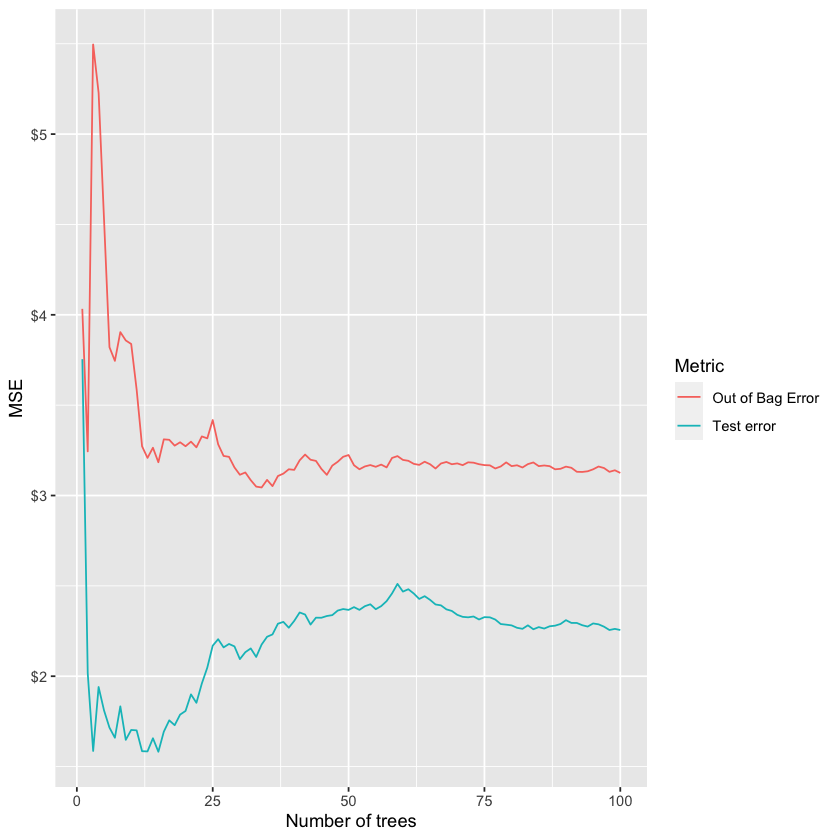

In [91]:
set.seed(101)
compare_oob_test_err_list <- compare_oob_test_err_func(train, test, p, b)
compare_oob_test_err_tab <- compare_oob_test_err_list$tab
compare_oob_test_err_mod <- compare_oob_test_err_list$model
compare_oob_test_err_tab

The above comparison shows that the OOB converges to the ape with a higher number of trees. Yet, the OBB error slightly overestimates the test error. This is also true for when applying RF. Therefore, this notebook uses the mse to evaluate the model fit and the ape to evaluate the prediction accuracy. The following table shows the mse and ape for Bagging.

In [92]:
bag_func <- function(train, test, p, b) {
    # This function conducts the Baggind method.
    # 
    # Input:
    #      train (df) - train data set.
    #      test (df) - test data set.
    #      p (scalar) - nr. of variables to consider, m = p.
    #      b (scalar) - nr. of trees.
    #
    # Outcome:
    #      bag_fit_t100 - est. bagging model on train data and b = 100.
    #      mint (scalar) - nr. of trees for opt. fit on train data.
    #      bag_error_mat (mat) - error matrix with mse and ape.
    #      bag_var_importance () - importance of variables.
    
    bag_fit_t100 <- randomForest(G3_math ~ ., data = train, mtry = p, ntree = b, importance = TRUE)
    mint <- which.min(bag_fit_t100$mse)
    bag_fit_mint <- randomForest(G3_math ~ ., data = train, mtry = p, ntree = mint, importance = TRUE)

    bag_var_importance <- as.data.frame(importance(bag_fit_mint))
    bag_var_importance <- bag_var_importance[order(bag_var_importance$"%IncMSE", decreasing = TRUE), ]

    bag_predict_train <- predict(bag_fit_mint)
    bag_predict_test <- predict(bag_fit_mint, newdata = test)
    
    bag_mse <- error_rate_func(bag_predict_train, train$G3_math)
    bag_ape <- error_rate_func(bag_predict_test, test$G3_math)
    bag_error_mat <- as.matrix(cbind(bag_mse, bag_ape))
    
    return(list(bag_error_mat = bag_error_mat, model100 = bag_fit_t100, mint = mint,
                importance = bag_var_importance))
}

In [93]:
# Set seed and run the Bagging estimation on the training data, estimate the mse and ape.
set.seed(12)
bag_res_list <- bag_func(train, test, p, b)

In [94]:
# Save the results from the Bagging model.
bag_fit_t100 <- bag_res_list$model100
mint <- bag_res_list$mint
bag_var_importance <- bag_res_list$importance
bag_error_mat <- bag_res_list$bag_error_mat

In [95]:
bag_fit_t100 # Estm. model.


Call:
 randomForest(formula = G3_math ~ ., data = train, mtry = p, ntree = b,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 34

          Mean of squared residuals: 2.824969
                    % Var explained: 87.22

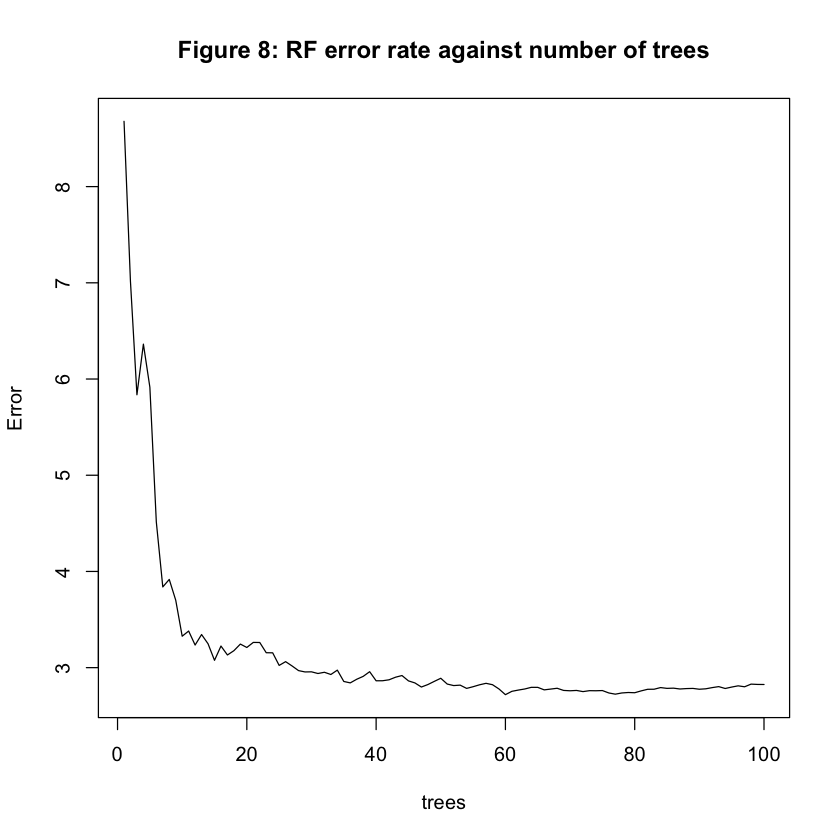

In [96]:
plot(bag_fit_t100, main = "Figure 8: RF error rate against number of trees")

The estimated Bagging model shows that 100 trees are not the optimal number of trees. In other words, there is another number of trees that provides a better model fit, a lower mse. This number is calculated in the function above and presented below. Then a new model is build, using the number of trees which minimises the mse since a better model fit is used as an indicator for a higher model accuracy.

In [100]:
mint # Tree with lowest mse on train data.

[1] 60

The importance of the variables for the prediction of the response is defined by the reduction in the mse that each variable provides when used for a split. The importance table below is produced by the function above. As expected, it shows that the last observed score for Mathematics, "G2_math" is also the most important predictor for the final score. In this model, the number of absences is considered as the second most important variable, reducing the test error further. All following variables contribute only marginally or even negatively to reduction of the test error.

In [102]:
bag_var_importance

,%IncMSE,IncNodePurity
,<dbl>,<dbl>
G2_math,39.24850251,4750.2559824
absences,17.59000130,932.3112979
age,2.46527882,77.3777475
sex,1.88059322,2.6583022
G1_math,1.87621038,39.0372868
address,1.57528520,0.9893862
reason,1.45765698,63.5596331
Mjob,1.41926146,18.3909962
guardian,1.24628219,3.2259418


Finally, let's have a look at the mse and ape of Bagging.

In [104]:
bag_error_mat # mse and ape.

bag_mse,bag_ape
3.0461,2.4982


##### Now lets loop over random seeds to make sure the results are not driven by the specific seed.
To make sure that the model fit is not driven by a specific seed, Bagging is applied, using different seeds. In the end, the average across the seeds is taken as the final result.

In [105]:
# Generate the random seeds here as above.
nr_random_seeds <- 5 # Nr. of random seeds to be generated.
set.seed(1010) # Set seed.
random_seeds <- round(runif(nr_random_seeds, 1, 1000)) # Draw random seeds.
random_seeds

[1] 553 192 185 678 912

In [106]:
bag_avrg_seed_func <- function(train, test, p, b, seeds) {
    # This function calculates the estimated mse and ape for the
    # Bagging model over the random seeds. 
    #
    # Input:
    #      train (df) - train data set.
    #      test (df) - test data set.
    #      p (scalar) - nr. of variables to consider, m = p.
    #      b (scalar) - nr. of trees.
    #      seeds (vector) - random seeds. 
    # Output:
    #
    # bag_error_mat_seeds (mat) - average error, mse and ape over the seeds. 
    
    # Initialize the matrix to store the results.
    bag_error_mat_seeds <- matrix( , nrow = length(seeds),
                             ncol = 3)
    # First column shows the seed number.
    bag_error_mat_seeds[, 1] <- seq(1:length(seeds))
    
    # Set counter.
    counter = 1
    for(si in seeds) {
        # Loop over random seeds and save the resulting errors.
        set.seed(si) # Set seed. 
        list_seed <- bag_func(train, test, p, b)
        bag_error_mat_seeds[counter, 2:3] <- list_seed$bag_error_mat
        # Increase counter.
        counter = counter + 1
    }
    
    return(as.matrix(bag_error_mat_seeds))
} 

In [107]:
# Calculate the average erorrs, mse and ape for the Bagging method over random seeds.
bag_error_mat_seeds_res <- bag_avrg_seed_func(train, test, p, b, random_seeds)

In [108]:
# Give column names to the matrix columns.
colnames(bag_error_mat_seeds_res) <- list("seed_position", "bag_mse", "bag_ape")

The following table shows the mse and ape for each seed. Both measures vary only slightly. This is not surprising since Bagging uses bootstrapping to build the model and is expected to be robust.

In [109]:
bag_error_mat_seeds_res

seed_position,bag_mse,bag_ape
1,3.2223,2.4313
2,3.0753,2.4262
3,3.0185,2.3292
4,2.9528,2.6496
5,2.9706,2.2717


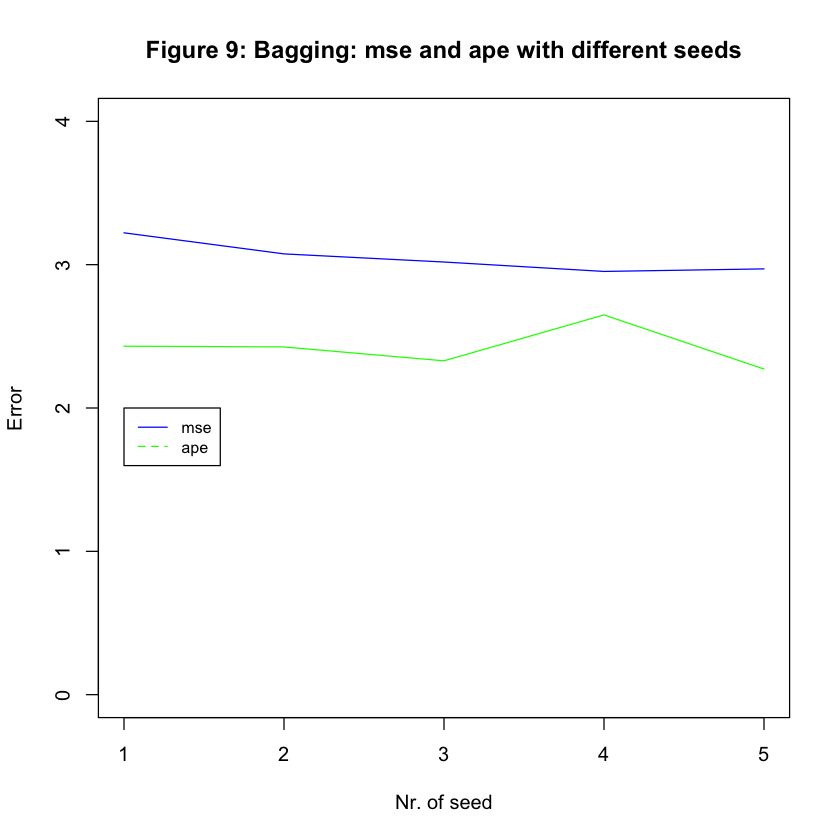

In [110]:
plot(bag_error_mat_seeds_res[, 1], bag_error_mat_seeds_res[, 2], type = "l", col = "blue", ylim = c(0, 4), main = "Figure 9: Bagging: mse and ape with different seeds",
     xlab = "Nr. of seed", ylab = "Error")
lines(bag_error_mat_seeds_res[, 1], bag_error_mat_seeds_res[, 3], col = "green")
legend(x = 1, y = 2, legend = c("mse", "ape"), col = c("blue", "green"), lty=1:2, cex=0.8)

Although there are only small differences across the different seeds, the average provides a more robust estimate. The following comparison of the mse and ape shows that the mse is larger than the ape by approximately 0.6 points. As usual, the model fit is better than the prediction accuracy. 

In [113]:
bag_error_mat_seeds <- rbind(colMeans(bag_error_mat_seeds_res[, 2:3]))
bag_error_mat_seeds

bag_mse,bag_ape
3.0479,2.4216


### 4.3 Random Forest  <a class="anchor" id="apprf"></a>

For RF, the number of variables that are considered at each split is almost equal to the square root of the total number of variables. As for Bagging, 100 trees are build and aggregated for the final prediction.

In [114]:
m <- round(sqrt(dim(train)[2])) # Number of random predictors which are considered at each split.
b <- 100 # Number of trees grown. 

In [115]:
rf_func <- function(train, test, m, b) {
    # This function conducts the RF estimation on the train data.
    #
    # Input:
    #      train (df) - train data set.
    #      test (df) - test data set.
    #      p (scalar) - nr. of variables to consider, m = p.
    #      b (scalar) - nr. of trees.
    #      seeds (vector) - random seeds. 
    #
    # Output:
    #
    #      rf_fit_t100 - est. RF model on train data and b = 100.
    #      mint (scalar) - nr. of trees for opt. fit on train data.
    #      rf_error_mat (mat) - error matrix with mse and ape.
    #      rf_var_importance () - importance of variables.   
    
    rf_fit_t100 <- randomForest(G3_math ~ ., data = train, mtry = m, ntree = b, importance = TRUE)
    mint <- which.min(rf_fit_t100$mse)
    rf_fit_mint <- randomForest(G3_math ~ ., data = train, mtry = m, ntree = mint, importance = TRUE)
    rf_var_importance <- as.data.frame(importance(rf_fit_mint))
    rf_var_importance <- rf_var_importance[order(rf_var_importance$"%IncMSE", decreasing = TRUE), ]
    
    rf_predict_train <- predict(rf_fit_mint)
    rf_predict_test <- predict(rf_fit_mint, newdata = test)
    
    rf_mse <- error_rate_func(rf_predict_train, train$G3_math)
    rf_ape <- error_rate_func(rf_predict_test, test$G3_math)
    rf_error_mat <- cbind(rf_mse, rf_ape)

    return(list(rf_error_mat = rf_error_mat, model100 = rf_fit_t100, mint = mint,
               importance = rf_var_importance))
}

In [116]:
# Set seed and run the RF algorithm on the training data, estimate the mse and ape.
set.seed(111)
bag_res_list <- rf_func(train, test, m , b)

In [117]:
# Save the results from the RF method.
rf_fit_t100 <- bag_res_list$model100
rf_mint <- bag_res_list$mint
rf_var_importance <- bag_res_list$importance
rf_error_mat <- bag_res_list$rf_error_mat

Plotting the mse against the number of trees shows that there is a number, lower than 100 that provides a better model fit. This number is exposed below and used to fit a new model.

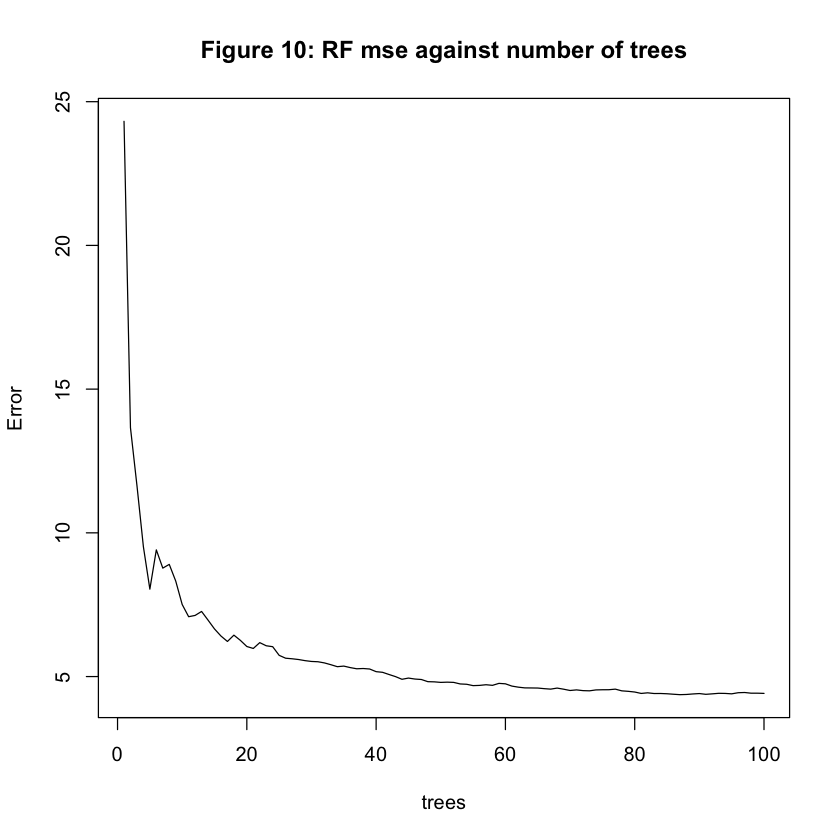

In [118]:
plot(rf_fit_t100, main = "Figure 10: RF mse against number of trees")

In [119]:
mint # Tree with lowest mse on train data.

[1] 60

As the Bagging model, the RF model picks the last observed score in Mathematics, "G2_math" as the most important variable to predict the final score. However, RF determines the first evaluation in Mathematics, "G1_math", as the second most important variable, followed by the number of absences. Contrary to Bagging, age has a lower importance.

In [120]:
rf_var_importance

,%IncMSE,IncNodePurity
,<dbl>,<dbl>
G2_math,12.32811546,2030.21672
G1_math,9.27805343,1277.10505
absences,8.45998395,468.93903
G1_port,3.47137077,322.78202
G2_port,3.40105513,347.98742
higher,2.92961732,66.85612
Walc,2.77020100,92.06123
failures,2.40267657,152.69771
schoolsup,2.38690736,42.38107


In [121]:
rf_error_mat

rf_mse,rf_ape
4.4941,3.6104


Again, to make sure that the results are not driven by chance, the model fit and prediction are conducted, using different seeds. The final result is then the average across the seeds.

In [122]:
rf_avrg_seed_func <- function(train, test, p, b, seeds) {
    # This function calculates the estimated mse and ape for the
    # RF model over the random seeds. 
    #
    # Input:
    #      train (df) - trai n data set.
    #      test (df) - test data set.
    #      p (scalar) - nr. of variables to consider, m = p.
    #      b (scalar) - nr. of trees.
    #      seeds (vector) - random seeds. 
    # Output:
    #
    # rf_error_mat_seeds (mat) - average error, mse and ape over the seeds. 
    
    # Initialize the matrix to store the results.
    # Initialize the matrix to store the results.
    rf_error_mat_seeds <- matrix( , nrow = length(seeds),
                             ncol = 3)
    # First column shows the seed number.
    rf_error_mat_seeds[, 1] <- seq(1:length(seeds))
    
    # Set counter.
    counter = 1
    for(si in seeds) {
        # Loop over random seeds and save the resulting errors.
        set.seed(si) # Set seed. 
        list_seed <- rf_func(train, test, p, b)
        rf_error_mat_seeds[counter, 2:3] <- list_seed$rf_error_mat
        # Increase counter.
        counter = counter + 1
    }
    
    return(as.matrix(rf_error_mat_seeds))
}

In [123]:
rf_error_mat_seeds_res <- rf_avrg_seed_func(train, test, m, b, random_seeds)

The following table shows the mse and ape for each seed individually. As for Bagging, the results do not show a notable deviation. Again, this is expected since RF, like Bagging, uses bootstrapping to build each decision tree. Nevertheless, the average across the different seeds provides a more robust result and confirms the nature of Bagging and RF. 

In [124]:
colnames(rf_error_mat_seeds_res) <- list("seed_position", "rf_mse", "rf_ape")
rf_error_mat_seeds_res

seed_position,rf_mse,rf_ape
1,5.0470,4.0221
2,4.7178,3.8498
3,4.1430,3.7445
4,4.7879,4.1902
5,4.6057,3.7969


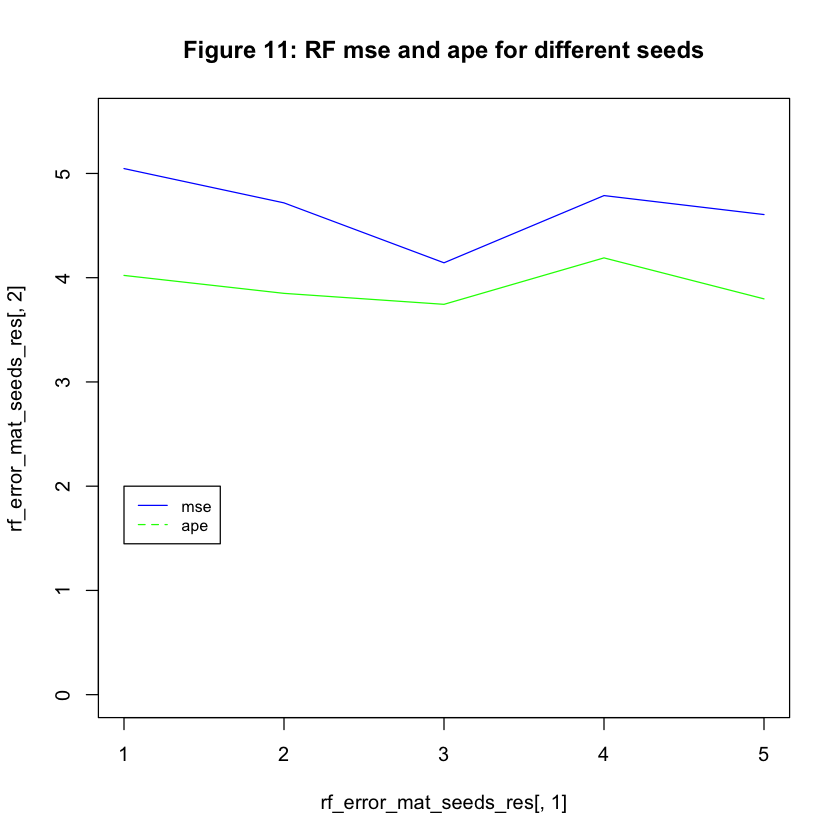

In [125]:
plot(rf_error_mat_seeds_res[, 1], rf_error_mat_seeds_res[, 2], type = "l", col = "blue", ylim = c(0, 5.5),
     main = "Figure 11: RF mse and ape for different seeds")
lines(rf_error_mat_seeds_res[, 1], rf_error_mat_seeds_res[, 3], col = "green")
legend(x = 1, y = 2, legend = c("mse", "ape"), col = c("blue", "green"), lty=1:2, cex=0.8)

In [126]:
rf_error_mat_seeds <- rbind(colMeans(rf_error_mat_seeds_res[, 2:3]))
rf_error_mat_seeds

rf_mse,rf_ape
4.66028,3.9207


### 4.4 Performance Evaluation  <a class="anchor" id="appeval"></a>

Now, let's summarize all results. 

The accuracy measures for the **LAO**:

In [127]:
lao_error_mat

lao_mse,lao_ape
4.730224,3.053762


The accuracy measures for the **Bagging** model:

In [128]:
bag_error_mat_seeds 

bag_mse,bag_ape
3.0479,2.4216


The accuracy measures for the **RF** model:

In [129]:
rf_error_mat_seeds

rf_mse,rf_ape
4.66028,3.9207


In [130]:
cbind(lao_error_mat, bag_error_mat_seeds, rf_error_mat_seeds)

lao_mse,lao_ape,bag_mse,bag_ape,rf_mse,rf_ape
4.730224,3.053762,3.0479,2.4216,4.66028,3.9207


The results show that Bagging overperforms RF and the simple LAO predictor. Bagging best fits the training data with a mse of 3.0, "bag_mse", and provides the highest prediction accuracy for the test data with an ape of 2.4, "bag_ape". While RF fits better the training data the LAO predictor provides a more accurate prediction. The mse for RF amounts to approximately 4.7 and is slighly below the mse of the LAO predictor of 4.7. Yet, the ape of the RF is close to 4 while the LAO predictor provides an ape of 3. <br/> 
Based on theory, these results might seem a bit surprising at the first glance. The theory suggest that Bagging provides an improvement to a simple DT and RF provides an additional improvement to Bagging by further decreasing the prediction variance. So why does Bagging outperforms RF? And why does the simple predictor provide a higher prediction accuracy than RF? As often, the answer can be found in the data.

The data reveals only few predictors with strong prediction power and many variables with low prediction power. For instance, while the results for Bagging and RF show that the previous score in Mathematics explains most of the variation, as confirmed by the LAO predictor, variables such as activities, father's job, family size, parental status etc. contribute very little or even negatively to the prediction accuracy (see for example parental status, "Pstatus" in the importance tables above). The low prediction power might indicate that there is truely no relationship between the predictor and the outcome. Yet, low prediction power of a variable might also be caused by the inability to colelct data appropriatly. To collect the data, students had to pick one of the few pre-defined options. For instance, the profession of the parents is summarized in four different categories: "at_home", "health", "services", "teacher", whereby the fifth one is "other". More than half of the students in the training set selected the fifth category "other" for their father's job. It is clear that the variable is not able to capture the true variation in the data and hence to provide useful information for the final score. This is demonstrated in the histogram below. 

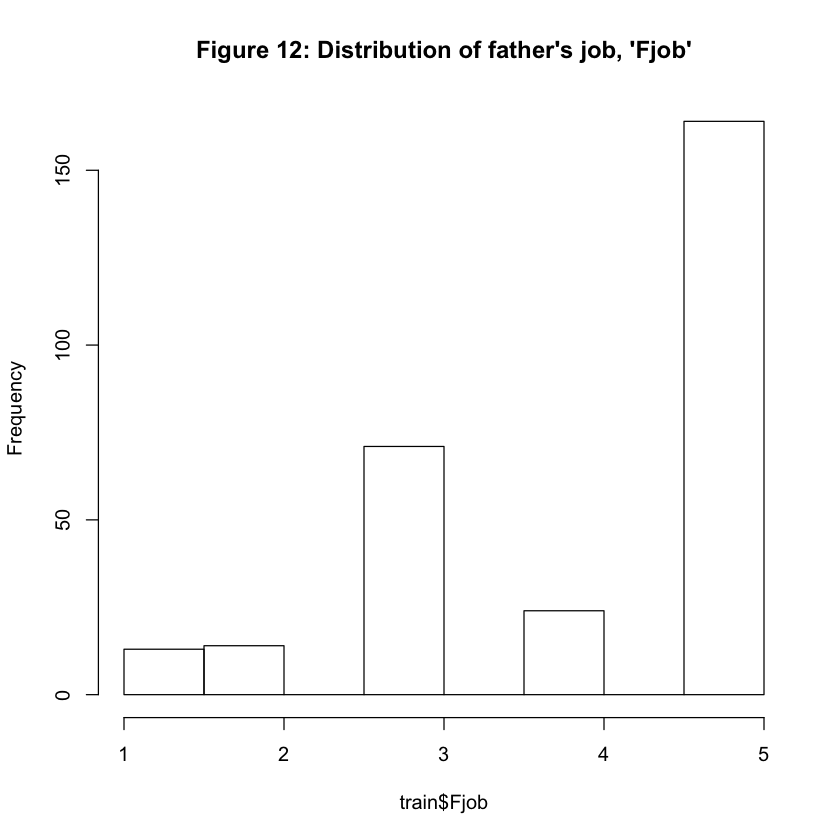

In [131]:
hist(train$Fjob, main = "Figure 12: Distribution of father's job, 'Fjob'")

Consequently, the data contains few important variables, predictors with a strong signal for the outcome and many variables with low signal. However, statistical learning algorithms cannot learn from variables that do not carry any systematic information about the outcome. Hence, the algorithms used are not able to estimate a systematic realtionship between predictors with a poor prediction power and the response. As a results, the algorithms provide a poor prediction accuracy. This feature is however more pronounced for RF than for Bagging or even the LAO predictor, but why? <br/>

Contrary to Bagging, RF decorrelates the trees by cosindering only a random subset of variables at each step. This might lead to a situation where RF excludes important variables with a strong signal and includes only variables with a low signal, providing a poor fit for the training data and a low prediction accuracy. This means that although RF decreases the variance of the model, it introduced a large bias to the prediction, growing the trees on variables that contain only very little information about the final score. Since there are more predictors with a low signal, it is more likely that the trees of RF are biased such that even building many trees and aggregating their results provides a poor estimation of the true score. This explains why Bagging outperforms RF and why the LAO predictor shows an even lower ape than RF. On this background, one can make the assumption that when the data sets contains few predictors with a strong signal and many predictors with a low signal, Bagging outperforms RF, as shown in the above application. However, in the cases where the data set contains mainly variabels with a strong signal or variabels with a low signal or variables of equal prediction power or signal, RF outperforms Bagging and the LAO predictor (except when the last observed score is the only important variable). 

To showcase this, the next section conducts a simulation study in which the three methods are applied on a subset of the available variables. This simulation study is described in the next section.

***
## 5 Simulation Study: subset of variables with high and low signal <a class="anchor" id="sim"></a>
***

The results in the application section (Section 2) show that RF provides the worst prediction accuracy. The reason is that the data contains only a few predictors with a low signal for the outcome variable and many variables with a low signal. The aim of the simulation study is to construct two scenarios in which RF outperforms Bagging. At the beginning, the variables in the data are sorted by their signal strength. For simplicity and framework of this project, signal strength is defined as the correlation with the outcome variable, i.e., the final Mathematics score. However, other measures could be used as well. In the first case, the variables are sorted by their correlation with the outcome variable from high to low. In the second case, the order of the variables is reversed. In the first scenario the first subset consists out of one variable, the predictor that shows the highest correlation with the outcome. Sequentially, other variables are included to the subset following the order such that in the final step the variable with the lowest correlation is included. In the second scenario, the first subset contains the variable that exposes the lowest correlation. In the final step, the variable with the highest correlation is included and the subset equals the initial set of the variables.

This simulation explores the question why RF performs poorly and in what cases RF outperforms Bagging and vv. The simulation starts by sorting the variables by their correlation (strong to weak correlation) with the final Mathematics score.

In [135]:
signal_vars_vec <- names(sort(cor(student_df)[, 33], decreasing = TRUE))[-1] # Exclude G3_math, the final score.
signal_vars_vec

[1] "G2_math"    "G1_math"    "G2_port"    "G1_port"    "higher"    
 [6] "Medu"       "Fedu"       "paid"       "reason"     "studytime" 
[11] "internet"   "famrel"     "absences"   "nursery"    "activities"
[16] "freetime"   "Mjob"       "Fjob"       "Walc"       "Dalc"      
[21] "famsup"     "Pstatus"    "health"     "school"     "schoolsup" 
[26] "guardian"   "address"    "goout"      "famsize"    "sex"       
[31] "traveltime" "romantic"   "age"        "failures"

As expected the last observed score in Mathematics shows the strongest correlation with the final score, followed by th other available scores in Mathematics and Portuguese. Having a romantic relationship, age and failures show only a low correlation with the final score.

In [136]:
length(signal_vars_vec) == dim(train)[2] - 1 # Sanity check.

[1] TRUE

In [137]:
maxvar <- length(signal_vars_vec) 
seq <- seq(1:maxvar) # Construct a sequence from 1 to maxvar.

maxvar

[1] 34

In [138]:
# Initialize matrices to store the results.
lao_error_sim <- cbind(matrix(, nrow = maxvar, ncol = 4))
bag_error_sim <- cbind(matrix(, nrow = maxvar, ncol = 2))
rf_error_sim <- cbind(matrix(, nrow = maxvar, ncol = 2))

In [140]:
maxvar <- length(signal_vars_vec) 

In [141]:
wrapper_sim_func <- function(train_data, test_data, signal_vars_vec, b, maxvar, start, range) {
    # This function is a wrapper function constructed for the simulation. It performs the model fit and 
    # evaluation on the test data and calculates the mse and ape for all methods considered.
    #
    # Input: 
    #      train_data (df) - training data
    #      test data (df) - test data
    #      signal_vars_vec (vector) - vector of variables sorted by their strength of corr. to the outcome, high to low
    #      b (scalar) - nr. of trees
    #      maxvar (scalar) - max. nr. of variables
    #      start (scalar) - starting value for the loop
    #      range (sequence) - range for the loop
    #
    # Output:
    #     lao_error_sim (matrix) - error matrix for LAO
    #     bag_error_sim (matrix) - error matrix for Bagging
    #     rf_error_sim (matrix) - error matrix for RF
    
    for(idx in range) {
        # The function loops over the sorted variables in the sample.
        
        # Pick the variables for each run.
        train_sim <- cbind(G3_math = train_data$G3_math, train_data[signal_vars_vec[start:idx]])
        test_sim <- cbind(G3_math = test_data$G3_math, test_data[signal_vars_vec[start:idx]])

        ### A Random Guess
        lao_train_sim <- train_sim$G2_math
        lao_test_sim <- test_sim$G2_math
        
        lao_mse_sim <- error_rate_func(lao_train_sim, train_sim$G3_math)
        lao_ape_sim <- error_rate_func(lao_test_sim, test_sim$G3_math)

        ### Bagging
        # Fit
        bag_m <- dim(train_sim)[2] - 1 # All vars considered at each split. 
        bag_fit_t100_sim <- randomForest(G3_math ~ ., data = train_sim,
                                    mtry = bag_m, ntree = b, importance = TRUE)

        # Look for the tree which gives the min. mse and use it for the fitting.
        bag_mint <- which.min(bag_fit_t100_sim$mse)
        bag_fit_mint_sim <- randomForest(G3_math ~ ., data = train_sim,
                                    mtry = bag_m, ntree = bag_mint, importance = TRUE)

        # Predict.
        bag_predict_train_sim <- predict(bag_fit_mint_sim)
        bag_predict_test_sim <- predict(bag_fit_mint_sim, newdata = test_sim)

        # Save MSE and APE.
        bag_mse_sim <- error_rate_func(bag_predict_train_sim, train_sim$G3_math)
        bag_ape_sim <- error_rate_func(bag_predict_test_sim, test_sim$G3_math)

        ### Random Forest
        # Fit
        rf_m <- round(sqrt(dim(train_sim)[2]))
        rf_fit_t100_sim <- randomForest(G3_math ~ ., data = train_sim,
                                    mtry = rf_m, ntree = b, importance = TRUE)

        # Look for the tree which gives the min. mse and use it for the fitting.
        rf_mint <- which.min(rf_fit_t100_sim$mse)
        rf_fit_mint_sim <- randomForest(G3_math ~ ., data = train_sim,
                                    mtry = rf_m, ntree = rf_mint, importance = TRUE)

        # Predict
        rf_predict_train_sim <- predict(rf_fit_mint_sim)
        rf_predict_test_sim <- predict(rf_fit_mint_sim, newdata = test_sim)

        # Save MSE and APE.
        rf_mse_sim <- error_rate_func(rf_predict_train_sim, train_sim$G3_math)
        rf_ape_sim <- error_rate_func(rf_predict_test_sim, test_sim$G3_math)

        # Save the error rates. Start from the second row since one varible is not considered.
        lao_error_sim[idx, 3:4] <- cbind(lao_ape_sim)
        bag_error_sim[idx, 1:2] <- cbind(bag_mse_sim, bag_ape_sim)
        rf_error_sim[idx, 1:2] <- cbind(rf_mse_sim, rf_ape_sim)
    
    }
    
    # Give names to columsn and fill in rows with consideres variables and variable nr.
    colnames(lao_error_sim) <- c("var_nr", "incl.vars", "lao_mse", "lao_ape")
    colnames(bag_error_sim) <- c("bag_mse", "bag_ape")
    colnames(rf_error_sim) <- c("rf_mse", "rf_ape")
       
    return(cbind(lao_error_sim, bag_error_sim, rf_error_sim))
}

As before, we build the models for different seeds to rule out the case where the results are driven by a specific seed.

In [142]:
average_seeds_func <- function(train_data, test_data, signal_vars_vec, b, maxvar, start, range, seeds) { 
    # Average the results over different seeds.
    # The wrapper function is described above, the input seeds represents the 
    # randomly chosen seeds.
    
    # Prepare the matrix for the average result. 
    avrg_mat <- matrix(0, nrow = maxvar, ncol = 8)
    
    for(si in seeds) {
        # Loop over the seeds and tale average of the results.
        set.seed(si)
        mat <- wrapper_sim_func(train, test, signal_vars_vec, b, maxvar, start, range)
        avrg_mat <- (avrg_mat + mat)/ 2

    }
    
    return(round(avrg_mat, 4))
}

In [143]:
nr_random_seeds <- 5 # Nr. of random seeds to be generated.
set.seed(111) # Set seed.
random_seeds2 <- round(runif(nr_random_seeds, 1, 1000)) # Draw random seeds.
random_seeds2

[1] 593 727 371 515 378

##### Run the simulation for the first case

Run the simulation for the first case: The simulation starts with a predictor which shows the highest correlation with the outcome. At each step, the variable with the next highest correlation is included. Finally, the simulation stops by performing the model fit and evaluation on the full data set, containing all initial variables.

In [144]:
mat_avrg_seeds_high_low <- average_seeds_func(train, test, signal_vars_vec, b, maxvar, 1, seq, random_seeds2)

In [145]:
mat_avrg_seeds_high_low[, 1] <- seq # The first column shows the nr. of the variable.
mat_avrg_seeds_high_low[, 2] <- signal_vars_vec # The second row shows the names ov the variables.

The following table shows the results of the first case in the simulation study. The first two columns represent the number and name of the variable in the subset. The following two columns, column three and four show the results for the LAO predictor, the mse and ape respectively. The consecutive two columns show the mse and ape for Bagging and the last two columns show the same evaluation measures for RF.

The first line shows that if only the previous score, "G2_math", and hence the predictor with the highest signal/ correlation is considered for the model fit, all three methods show a similar prediction accuracy, ape. This is expected since Bagging and RF are the same when considering the same variables for the model fit. However, after introducing the seventh variable, "Fedu", to the subset, Bagging outperforms RF more notably. Before that, RF outperforms Bagging only when the last two scores for Mathematics are considered, "G2_math" and "G1_math". Bagging outperforms RF only very slighly. After introducing more and more variables to the subset, the discrepancy between the Bagging ape and RF ape increases as expected. Here, one can see that the bias which is introduced by the RF outgrows the reduction in the model variance. The ape of RF exceeds the Bagging ape by more than one. In line 34, where all 34 variables are considered, the results are very close to the ones generated in the application section.

In [154]:
mat_avrg_seeds_high_low

var_nr,incl.vars,lao_mse,lao_ape,bag_mse,bag_ape,rf_mse,rf_ape
1,G2_math,2.4723,2.4723,4.0849,2.5729,2.6345,2.7618
2,G1_math,2.4723,2.4723,3.6022,2.6696,4.6123,2.3606
3,G2_port,2.4723,2.4723,5.1974,2.7259,5.0942,2.8073
4,G1_port,2.4723,2.4723,5.1282,2.9742,5.206,3.1494
5,higher,2.4723,2.4723,4.9488,3.0827,5.0426,3.3031
6,Medu,2.4723,2.4723,5.227,2.5852,5.2223,2.8557
7,Fedu,2.4723,2.4723,4.9428,3.1814,5.2044,3.1619
8,paid,2.4723,2.4723,4.8819,3.3607,5.246,3.2732
9,reason,2.4723,2.4723,4.9425,3.2828,5.1236,3.4846
10,studytime,2.4723,2.4723,4.5657,2.8312,5.2466,3.4059


The following two figures, present the results above. The first figure shows the mse on the y-axis and the number of variables in the subset on the x-axis. Again, the variables are ordered by their signal, their correlation to the outcome, from high to low.

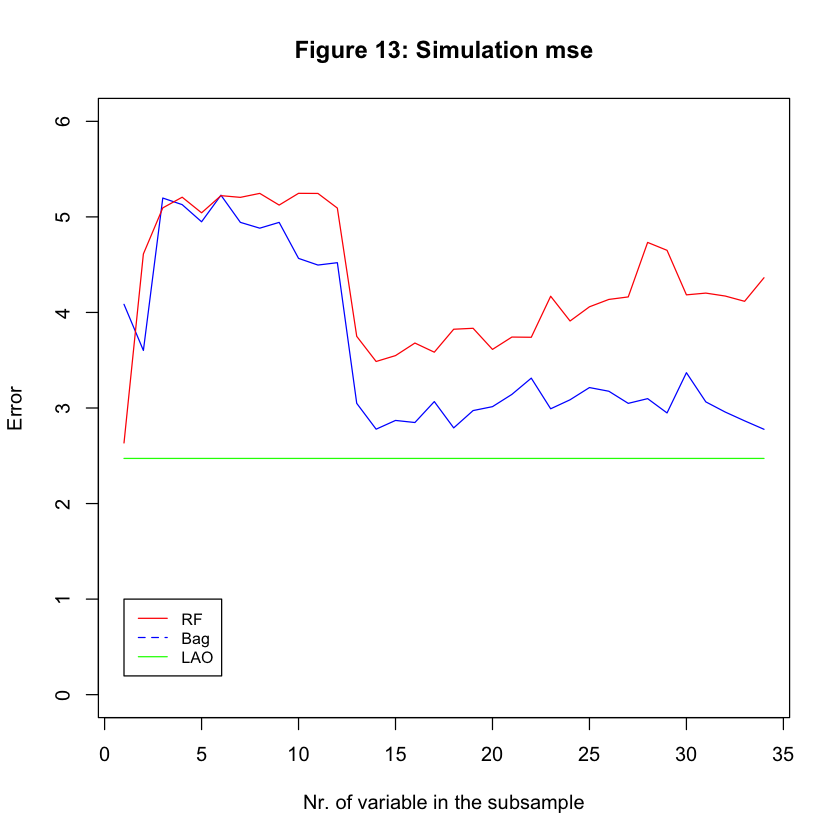

In [155]:
plot(mat_avrg_seeds_high_low[, 1], mat_avrg_seeds_high_low[, 5], type = "l",
     col = "blue", ylim = c(0, 6), main = "Figure 13: Simulation mse",
     xlab = "Nr. of variable in the subsample", ylab = "Error")
lines(mat_avrg_seeds_high_low[, 1], mat_avrg_seeds_high_low[, 7], col = "red")
lines(mat_avrg_seeds_high_low[, 1], mat_avrg_seeds_high_low[, 3], col = "green")
legend(1, 1, legend=c("RF", "Bag", "LAO"),
       col=c("red", "blue", "green"), lty=1:2, cex=0.8)

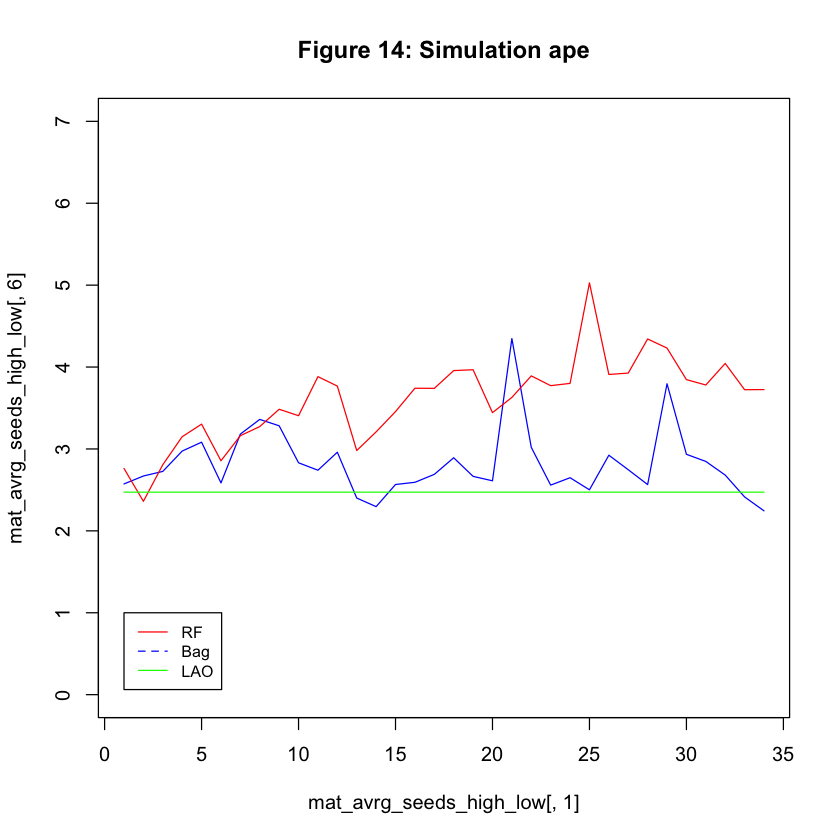

In [156]:
plot(mat_avrg_seeds_high_low[, 1], mat_avrg_seeds_high_low[, 6],
     type = "l", col = "blue", ylim = c(0, 7), main = "Figure 14: Simulation ape",)
lines(mat_avrg_seeds_high_low[, 1], mat_avrg_seeds_high_low[, 8], col = "red")
lines(mat_avrg_seeds_high_low[, 1], mat_avrg_seeds_high_low[, 4], col = "green")
legend(1, 1, legend=c("RF", "Bag", "LAO"),
       col=c("red", "blue", "green"), lty=1:2, cex=0.8)

The results show that at first, when variables with a high signal are considered, RF outperforms Bagging or performs equally to Bagging. After more and more variables with a lower correlation are introduced, Bagging outperforms RF in most cases. The LAO predictor outperforms both methods most of the times, except when the model fit is conducted on the full sample. This is becuase the LAO predictor always uses the predictor with the strongest signal for its prediction. When all variables are considered, Bagging performs best as shown in the application section.

##### Now let's revert the order of the variabels!

The order of the variables is reversed in the second scenario of the simulation. Now, the first variable has the lowest correlation with the outcome while the last variable the highest. Since we consider the previous score for Mathematics, "G2_math", only in the very last step, the LAO predictor is not considered here.

In [157]:
mat_avrg_seeds_low_high <- average_seeds_func(
    train, test, signal_vars_vec, b, maxvar, maxvar, rev(seq), random_seeds2)

In [158]:
mat_avrg_seeds_low_high[, 1] <- seq
mat_avrg_seeds_low_high[, 2] <- signal_vars_vec

As above, the following table shows the resuls for the simulation. The columns are to be interpreted as above. However, this time, the variables are considered in a reverted order, from the bottom to the top. The 34th and last variable exposes the lowest correlation with the outcome and hence is considered first in the subset, here it is the variables that represents the number of failures, "failures". The variables above are added to the subset sequentially until the variable with the highest correlation, "G2_math", is included and the results are close the to ones in the application section (see line 1 in the following table).

Reading the table from the bottom to the top, we can see that building the models on only the first variable results in large error rates. Since there is only one variable to consider, the error rate of Bagging and RF are very similar. As expected, including more and more variables with a low signal does not provide a notable improvement for Bagging. Yet, including more varibales with a low signal improves the model fit and prediction accuracy of RF. This is because RF reduces the model variance while a bias i sintroduced to both methods, RF and Bagging, since both sonsider only variables with a low signal. Almost until the half, RF slightly overperforms Bagging. After including the variable nr. 17, that represents the mother's job, "Mjob", Bagging overperforms RF in the model fit and shows a higher prediction accuracy.

In [331]:
mat_avrg_seeds_low_high

var_nr,incl.vars,lao_mse,lao_ape,bag_mse,bag_ape,rf_mse,rf_ape
1,G2_math,2.4723,2.4723,3.2152,2.3157,4.5052,3.9322
2,G1_math,NaN,NaN,5.3511,7.739,7.0241,6.8037
3,G2_port,NaN,NaN,12.9436,11.8231,12.6461,11.1112
4,G1_port,NaN,NaN,13.1886,12.4187,13.2973,12.494
5,higher,NaN,NaN,16.0641,13.9443,15.4389,13.8594
6,Medu,NaN,NaN,15.1811,13.0214,15.6619,14.2536
7,Fedu,NaN,NaN,15.8398,13.2085,15.6801,14.9293
8,paid,NaN,NaN,15.427,13.0997,15.2878,14.0124
9,reason,NaN,NaN,15.1926,13.6971,15.2989,13.9306
10,studytime,NaN,NaN,14.973,13.1723,15.23,14.6273


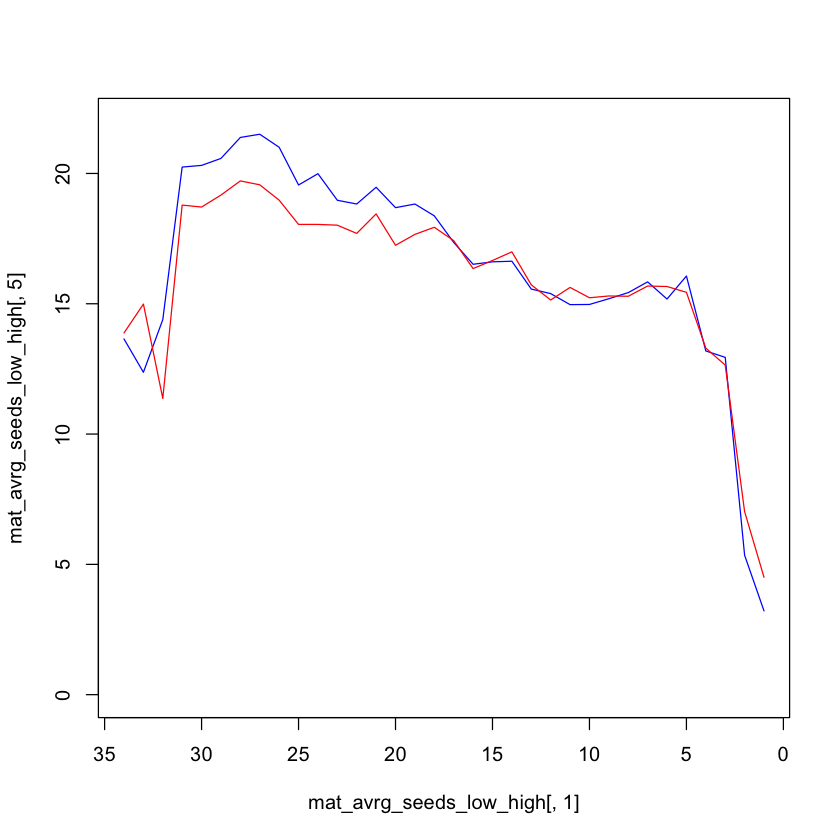

In [160]:
plot(mat_avrg_seeds_low_high[, 1], mat_avrg_seeds_low_high[, 5],
     type = "l", col = "blue", ylim = c(0, 22), xlim = rev(range(1:34)))
lines(mat_avrg_seeds_low_high[, 1], mat_avrg_seeds_low_high[, 7], col = "red")
# Note: The lao predictor cannot be applied here.

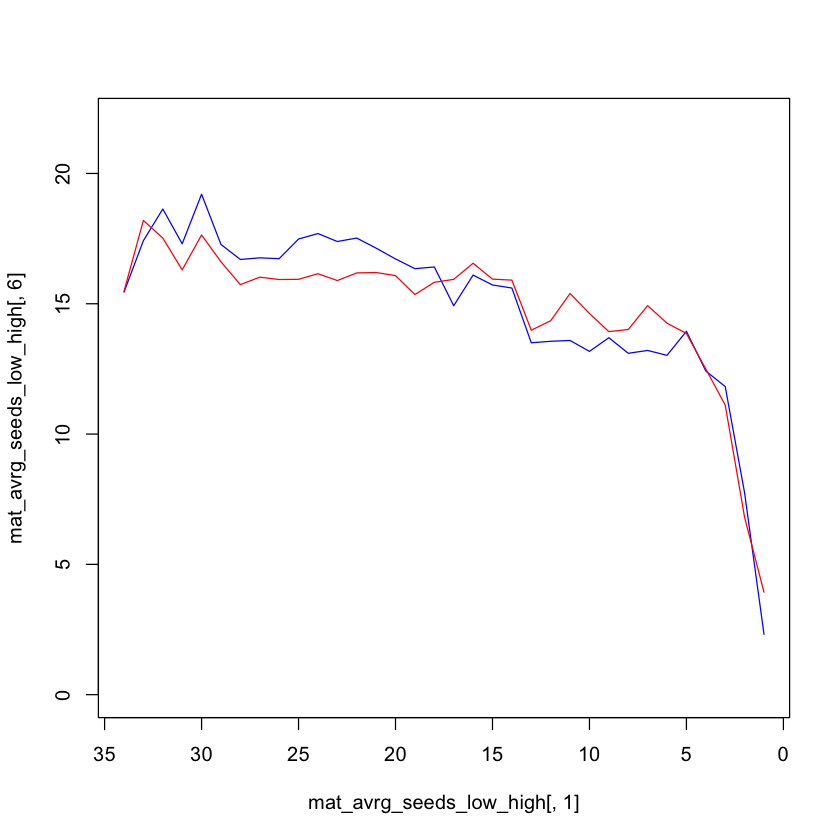

In [161]:
plot(mat_avrg_seeds_low_high[, 1], mat_avrg_seeds_low_high[, 6],
     type = "l", col = "blue", ylim = c(0, 22), xlim = rev(range(1:34)))
lines(mat_avrg_seeds_low_high[, 1], mat_avrg_seeds_low_high[, 8], col = "red")
# The lao predictor cannot be applied here.

To sum up, the simulation shows first that Bagging outperforms RF and that RF is even outperformed by a simple LAO predictor when the data set includes a relatively large number of variables with a low signal. In this case, the advantage of RF, the reduction of the variance through decorralization of the trees becomes a disadvantage. When the number of variables with low signal is large, RF is likely to consider variables with a low signal for the splitting rules, introducing a bias to the model. Second, the simulation shows that RF outperforms Bagging when there are sufficient variables with a high signal or many variables with low signal. In the latter case, the virtue of the RF is an advantage since RF decreases the model variance while the model bias is supposed to be similar for both methods. <br/>
Finally, the simulation study confirms the expectations and underlines the importance of understanding data collection tools and methods, the data structure and the application of an appropriate statistical learning tool to achieve a higher prediction accuracy. 

***
## 6. Conclusion <a class="anchor" id="conclusion"></a>
***

Cortez and Silva (2008) see the increase of data availability and the emergence of statistical learning tools in sociological research as an opportunity to study the potential of DM methods and tools in the educational sector. The authors apply supervised machine learning algorithms such as Random Forest to predict the performance of Portuguese students in two core subjects, Mathematics and Portuguese. They build their models on demographic, social and performance data. They conclude that DM methods provide high predictive accuracy and uncover important variables which affect the performance of students.

Following the example of Cortez and Silva (2008), this notebook evaluates the prediction performance of Bagging and RF. Given the limitation of this student project, the notebook uses these methods to predict the final score in Mathematics. For a basic reference, both methods are compared to a simple predictor which predicts the last available observation for the final score. The theory suggests that Bagging provides an improvement over a simple DT and RF provides an additional improvement over Bagging by further reducing the model variance. However, the results show that Bagging overperforms RF and RF provides an even lower prediction accuracy than the simple LAO predictor. Why does RF performs so poorly? The simulation study aims to shed light on this question. The simulation study shows that Bagging outperfroms RF when the data contains only few predictors with a strong signal and many predictors with a low signal. However, when the data contains mostly variables with a high or low signal, RF outperforms Bagging. The LAO predictor provides a high prediction accuracy and outperforms both methods most of the cases. 

The reason is that contrary to Bagging, RF decorrelates the trees by cosindering only a random subset of variables at each step. This might lead to a situation where RF excludes important variables with a strong signal and includes only variables with a low signal, providing a poor fit for the training data and a low prediction accuracy. This means that although RF decreases the variance of the model, it introduced a large bias to the prediction by growing the trees on variables that contain only very little information on the outcome. Since the data set in this example contains more predictors with a low signal, it is more likely that the trees of RF are biased such that even the aggregated result of many trees provides a poor estimation of the true score. This explains why Bagging outperforms RF. The LAO predictor shows a relatively high prediction accuracy since it uses the strongest predictor in the data set to predict the outcome. Hence, its prediction takes in the most important information and its accuracy is not deluted by the predictors with a very low prediction power. 

On this background, one may conclude that when the data sets contains few predictors with strong signal and many predictors with low signal, Bagging outperforms RF. However, in the two cases where the data set contains mainly variables with a strong signal or variables with a low signal, RF outperforms Bagging. A simple predictor provides a high prediction accuracy in case where there is one explanatory varibale with the most explanatory power while the rest of the variables have a low or nor signal for the outcome.

To sum up, the advantage of RF, the reduction of the variance through the decorralization of the trees becomes a disadvantage when the number of variables with low signal is reöatively large. While RF decreases the model variance, it increases the model bias by considering variables with a low signal. As a result, this simulation study highlights the importance of understanding the data collection, data structure and the methods used in detail to apply the appropriate statistical learning tool to the available data. Understanding how to collect data correctly, adapting questionnaires to the target group and most importantly how to chooce an appropriate statistical learning tool for the data given, helps to achieve a higher prediction accuracy. 